<h1>Analysis of local precipitation and temperature affects on plains grass growth in northern Colorado</h1>

<h2>Project Overview</h2>

<p>In this project, using data from the US Department of Agriculture, Agricultural Research Service, and the SC-ACIS (Applied Climate Information System), I analyze the relationship between aboveground net primary productivity (ANPP, a measure of plant biomass weight per unit area) of multiple plant species groups, and the average monthly precipitation and temperature data in north central Colorado, USA. This analysis is performed using support vector machine regression (SVR) estimators, which are supervised learning models, with tasks done include data cleaning, exploritory data analysis to determine viable routes of investigation, feature multicollinearity inspection and curating, model generation using hyperparameter tuned SVR estimators, and model evalutaion.</p>
<p>Models were generated for each combination of sample collection site and known plant group species, along with three possible sets of features: average monthly precipitation, average monthly temerature, and both average monthly precipitation and temperature. All feature sets are insepcted for multicollinearity, with features optimally selected to decrease VIF values below 5 and maximize number of features.</p>
<p>After model fitting and prediction evaluation, it was found that with present data over consistant date ranges, all sets of features were able to perform similarly well or poorly for a given site and plant group, implying multiple possible areas of further investigation, including adding more features, such as soil temperature data, or more filtering of feature sets, to improve performance. Using both monthly temperature and precipitation as model features generated the largest number of best performing models as measured using $R^2$ values, but the best performing models using that feature set could not do better than the best performing models using only monthly temperature as features.</p>

<h2>Goals and Motivations</h2>

<p>The primary goal of this project is to determine if the yearly grass and flowering plant growth data contained in the data can be explained using local precipitation and temperature data. This includes investigating how local rainfall and temperatures affect each species grouping within the data, and if the use of precipitation and temperature data seperately or together improves model accuracy.</p>
<p>My reason for investigating these questions is a desire to see if just two types of data, rainfall and temperature, are enough to explain the grass growth in this ecosystem, or if more data is required. The success and failure of ecological systems are dependant on complicated interactions between plants, animals, local weather and overall climate, and soil nutrient levels, temperature and microbial activity. If data describeing only daily rainfall and temperature is enough to accurately predict plant growth of those plant species groups in this biome, predictions could be made for plant growth of these species in other areas of the planet. Since many animal species rely on grasses for food, such as cattle, sheep, deer, and antelope, and predators in turn rely on them as their food source, being able to predict grass growth year to year with minimal data could help simplify predictions of animal migrations and ecosystem changes as climate change progresses. This can also be used in economic predictions relating to cattle grazing in areas where these plants are numerous.


<h2>Libraries, functions and dataframes</h2>

<h3>Imported libraries and functions</h3>

In [1]:
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import r2_score
import altair as alt
import seaborn as sns
from IPython.core.display import HTML
from IPython.display import display, Markdown, Latex
import calendar
from calendar import monthrange
import datetime
from scipy.stats import normaltest
from scipy.stats import norm 
import pylab 
import statsmodels.api as sm
from scipy import signal
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from matplotlib.colors import Normalize
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")

<h3>Dataframes generated from imported data</h3>

In [2]:
'''

'''

gfpd_path = 'https://data.nal.usda.gov/system/files/CPER-PPT_gapfilled_1980-2018.csv'
gfpd_dict_path = 'https://data.nal.usda.gov/system/files/CPER-PPT_DataDictionary.csv'
ltanpp_path = 'https://data.nal.usda.gov/system/files/CPER-LTNPP_bypft_1983-2018.csv'
ltanpp_dict_path = 'https://data.nal.usda.gov/system/files/CPER-LTNPP_bypft_1983-2018_DataDictionary.csv'
species_dict_path = 'https://data.nal.usda.gov/system/files/CPER-LTNPP_bypft_1983-2018_SppInFG_DataDictionary.csv'

gfpd = pd.read_csv(gfpd_path)
gfpd_dict = pd.read_csv(gfpd_dict_path)
ltanpp = pd.read_csv(ltanpp_path)
ltanpp_dict = pd.read_csv(ltanpp_dict_path)
species_dict = pd.read_csv(species_dict_path)

gfpd['Date'] = gfpd['Date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').strftime('%Y-%m-%d'))
'''
temperature data
'''

def replaceChar(path):
    return path.replace('\\', '/') 


temp_path = 'https://raw.githubusercontent.com/KyleRitland/ANPP-analysis-project/main/Nunn%207%20NNE%20temp%20data.txt'
final_temp_path = replaceChar(temp_path)
cols = ["Date", "MaxTemperature", "MinTemperature", "AvgTemperature", "AtObsTemperature", "Precipitation"]

nunn_7_NNE = pd.read_csv(temp_path, sep=",", header=None) # dates: 2003-07-07 - 2018-12-31
nunn_7_NNE.columns = cols

#cper_temp_path = r"C:\Users\kgrit\OneDrive\Documents\UC boulder Data science masters\Intro to machine learning\final project\temp data\CPER temp data.txt"
#final_cper_temp_path = replaceChar(cper_temp_path)
#cols_2 = ["Date", "MaxTemperature", "MinTemperature", "AvgTemperature", "AtObsTemperature"]

#cper = pd.read_csv(final_cper_temp_path, sep=",", header=None) # dates: 2013-09-13 - 2018-12-31
#cper.columns = cols_2


for df in [nunn_7_NNE]:
    for i in df.columns:
        if i == 'Date':
            df[i] = pd.to_datetime( df[i], errors='coerce')
        else:
            df[i] = pd.to_numeric( df[i], errors='coerce')
            if i == "Precipitation":
                df[i] = df[i]*25.4 #convert inches to mm

numPlantsPerGroup = {'FORB': 56, 'WSPG': 10, 'CSAG': 2, 'CSPG': 12, 'UNGR': 'unknown', 'UNKN': 'unknown'}

<h3>Helper functions</h3>

<h4>General helpers</h4>

In [3]:
def get_var(input_var, name): 
    
        
    try:
        #print('name',name)
        #print('tf',input_var[name],'works',input_var[name]==True or input_var[name]==False )
        #print('\n\n')
        return input_var[name]
    except:
        print(name, 'not found')
        return False


<h4>Exploritory data analysis helpers</h4>

<h5>calculations</h5>

In [4]:
def creatDtCols(_df):

        new_df = _df.copy()
        _sub_date = pd.to_datetime(new_df['Date']).dt
        new_df['Year'] = _sub_date.year
        new_df['Month'] = _sub_date.month
        new_df['DayOfMonth'] = _sub_date.day
    
        return new_df

def print_missing_values(_df, _cols, year_thresh, month_thresh):
    
    def print_year_month(_year, un_months, _col, _query):
        
        for i in range(len(un_months)):
            _m = un_months[i]
            _q_month = _query & (_df[_col] >= float(-np.inf)) & (_df['Month'] == _m)
            _count = _df[_q_month].shape[0]
            _m_total = monthrange(_year, _m)[1]
            _per = round(100*_count/_m_total,2)
    
            _str_m = f'<span style="color:black; padding-left: {4}%">Column: {_col}</span>'
            _str_m_2 = f'<span style="color:red; padding-left: {8}%">Month {_m}, count: {_count}, days in month: {_m_total}, {_per}% of data present w.r.t. days/month</span>'
            
            if _count > 0 and _per < month_thresh:
                display(Markdown( _str_m))
                display(Markdown( _str_m_2))
    '''
    start
    '''
    un_years = _df['Year'].unique()
    un_months = _df['Month'].unique()
    #_cols = ['MaxTemperature','MinTemperature','AvgTemperature']
    
    print('Check for missing values in temperature')
            
    for _year in un_years:
            
        #_year = un_years[a]
        _query = (_df['Year'] == _year) #& (_df[_cols[0]] >= float(-np.inf)) & (_df[_cols[1]] >= float(-np.inf)) & (_df[_cols[2]] >= float(-np.inf))
        for _col in _cols:
            _query = _query & (_df[_col] >= float(-np.inf))
            
        _count = _df[_query].shape[0]
        _year_tot = (365+calendar.isleap(_year))
        _per = round(100*_count/_year_tot,2)
        _str_year = f'<span style="color:black; padding-left: {0}%">{_year} count: {_count}, days in year: {_year_tot}, {_per}% of daily data present w.r.t. days/year</span>'
    
        if _count > 0 and _per < year_thresh:
            display(Markdown( _str_year))

            for _col in _cols:
                print_year_month(_year, un_months, _col, _query)
            #temp_print_year_month(_year, _cols[1], _query)
            #temp_print_year_month(_year, _cols[2], _query)

def plant_growth_print_missing_data():

    def helper(_arr, _col, _query, _t):
        _str = ''; _val = _arr; _query_main = _query & (ltanpp[_col] == _val); _count = ltanpp[_query_main].shape[0]
        return [_str + f'{_col} "{_val}" count: {_count} of {_t},', _query_main, _count]

    def r_helper(_c,_d):
        return round(100*_c/_d,2)

    def r_print(_s, _str_1, _c_1, _n_1):
        _r = r_helper(_c_1, _n_1)
        if _r < 100:
            display(Markdown(f'<span style="color:red; padding-left: {_s}%">\n{_str_1} {_r}% of data present ***\n</span>'))
        else:
            display(Markdown(f'<span style="padding-left: {_s}%">{_str_1} {_r}% of data present</span>'))
        
    '''
    Start
    '''
    un_years = ltanpp['Year'].unique()
    un_plants = ltanpp['PFT'].unique()
    un_plot = ltanpp['Plot'].unique()
    un_transect = ltanpp['Transect'].unique()
    un_site = ltanpp['Site'].unique()

    display(Markdown( f'<span>Display missing plant growth data</span>'))
    _cs = [270, 90, 30, 6]
    for a in range(len(un_years)):
    
        _year = un_years[a]
        _query = (ltanpp['Year'] == _year)
        _count = ltanpp[_query].shape[0]
        
        if _count < _cs[0]:
            display(Markdown( f'<span style="color:red;">{_year} count: {_count} of {_cs[0]}, {r_helper(_count, _cs[0])}% of data present</span>'))
            
            for b in range(len(un_site)):
                
                [str_site, _query_site, _count_site] = helper(un_site[b], 'Site', _query, _cs[1])
                r_print(4, str_site, _count_site, _cs[1])

                if _count_site < _cs[1]:
                    
                    for c in range(len(un_transect)):
                        
                        [str_transect, _query_transect, _count_transect] = helper(un_transect[c], 'Transect', _query_site, _cs[2])
                        r_print(8, str_transect, _count_transect, _cs[2])
                        
                        if _count_transect < _cs[2]:
                            
                            if _count_transect > 0:
                                for d in range(len(un_plot)):
                                
                                    [str_plot, _query_plot, _count_plot] = helper(un_plot[d], 'Plot', _query_transect, _cs[3])
                                    r_print(12, str_plot, _count_plot, _cs[3])
                                        
                                    if _count_plot < _cs[3]:
                                        
                                        if _count_plot > 0:
                                            for e in range(len(un_plants)):
                                                
                                                [str_plant, _query_plant, _count_plant] = helper(un_plants[e], 'PFT', _query_plot, _cs[4])
                                                
                                                if _count_plant < 1:
                                                    print(' '*16 + str_plant)


'''
functions for rain and temperature analysis
'''

def get_vals(_arr, by_year=False, by_year_col=None, by_month=False):
    
    if by_year:
        df1_copy = _arr[0][1][0].copy() 
        df2_copy = _arr[0][1][1].copy() 
        
        df1_copy['Date'] = pd.to_datetime( df1_copy['Date'], errors='coerce')
        df2_copy['Date'] = pd.to_datetime( df2_copy['Date'], errors='coerce')

        df1_copy['Year'] = df1_copy['Date'].apply(lambda x: x.year)
        df2_copy['Year'] = df2_copy['Date'].apply(lambda x: x.year)
       
        display(df1_copy)
        display(df2_copy)
        int_col = 'rainfall diff'
        df = pd.DataFrame(df1_copy[by_year_col[0]] - df2_copy[by_year_col[1]], columns=[int_col])
        df['Year'] = df1_copy['Year']

        df = df.reset_index(drop=True)
        #print('first', arr_copy) 
        years = df1_copy['Year'].unique()

        display(df)
        print(years)
        
        _dates = []
        _mean = []
        _var = []
        _sd = []

        for i in range(len(years)):
                
            _vals = df[df['Year'] == years[i]]
            print(years[i])
            _vals = _vals[int_col]
            print(_vals)
            _dates.append(years[i])
            _mean.append( np.mean(_vals) )
            _int_var = np.var(_vals)
            _var.append( _int_var )
            _sd.append( np.sqrt( _int_var ) )

                    
        return {'dates': _dates, 'mean': _mean, 'variance': _var, 'sigma': _sd}#, 'bounds': [_mean-_sd*2, _mean+_sd*2]} 
            
    elif by_month:
        
        df1_copy = _arr[0][1][0].copy() 
        df2_copy = _arr[0][1][1].copy() 
        
        df1_copy['Date'] = pd.to_datetime( df1_copy['Date'], errors='coerce')
        df2_copy['Date'] = pd.to_datetime( df2_copy['Date'], errors='coerce')

        df1_copy['Year'] = df1_copy['Date'].apply(lambda x: x.year)
        df2_copy['Year'] = df2_copy['Date'].apply(lambda x: x.year)

        df1_copy['Month'] = df1_copy['Date'].apply(lambda x: x.month)
        df2_copy['Month'] = df2_copy['Date'].apply(lambda x: x.month)

        display(df1_copy)
        display(df2_copy)
        int_col = 'rainfall diff'
        df = pd.DataFrame(df1_copy[by_year_col[0]] - df2_copy[by_year_col[1]], columns=[int_col])
        
        df['Year'] = df1_copy['Year']
        df['Month'] = df1_copy['Month']
        df['Actual'] = df1_copy[by_year_col[0]]
        df['Verify'] = df2_copy[by_year_col[1]]
        df = df.reset_index(drop=True)
        #print('first', arr_copy) 
        
        years = df1_copy['Year'].unique()
        years.sort()
        months = df1_copy['Month'].unique()
        months.sort()

        #display(df)
        #print(years)
        
        _dates = []
        _mean = []
        _var = []
        _sd = []
        _perc_of_whole = []
        _flag = []
        
        for i in range(len(years)):

            for j in range(len(months)):

                print(years[i], months[j])
                
                _df = df[(df['Year'] == years[i]) & (df['Month'] == months[j])]
                _vals = _df[int_col]
                
                print(_vals)
                
                _dates.append(f'{years[i]}-{months[j]}')
                _m = np.mean(_vals)
                _mean.append( _m )
                _int_var = np.var(_vals)
                _var.append( _int_var )
                _sd.append( np.sqrt( _int_var ) )
                
                if _df['Actual'].shape[0] == 0:
                    print('shape = 0')
                    _perc_of_whole.append( 0 )
                else:
                    _per_m = np.mean(_df['Actual'])
                    if _per_m == 0:
                        print('shape != 0, mean is 0')
                        print(_df)
                        if np.mean( _df['Verify']) == 0:
                            _perc_of_whole.append( 0 ) 
                        else:
                            _perc_of_whole.append( -100 ) 
                            _flag.append([years[i], months[j],_df])
                    else:
                        _per = abs(_mean[-1])/_per_m
                        _perc_of_whole.append( _per )
                        if _per > 5:
                            _flag.append([f'year: {years[i]}', f'month: {months[j]}', f'mean: {_m}', f'percent: {_perc_of_whole[-1]}', _df])

        return {'dates': _dates, 'mean': _mean, 'variance': _var, 'sigma': _sd, 'percent of actual': _perc_of_whole, 'flag': _flag} 
        
    else:
        _mean = np.mean(_arr)
        _var = np.var(_arr)
        _sd = np.sqrt(_var)
        #print('var', _var, 'sd', _sd, 'mean', _mean)
        _s = [i for i in _arr if i < _mean-_sd*2 or i >  _mean+_sd*2]
        #print('_s \n',_s)
        #print('len of _s:', len(_s), 'len of _y_a_2:', len(_arr), 'frac:', 100*(len(_arr)-len(_s))/len(_arr))
        #print('95% of diffs fall between: [' + str(_mean-_sd*2) + ',' + str( _mean+_sd*2) + ']')
    
        return {'mean': _mean, 'variance': _var, 'sigma': _sd, 'bounds': [_mean-_sd*2, _mean+_sd*2]} 


def creat_copies(input_dfs):
    
    _dfs = {}
    
    for key in input_dfs:
        _new_key = key + " copy"
        _dfs[_new_key] = input_dfs[key].copy()
        
    return _dfs

def get_dates(_keys,_dfs, _date, _b_a = "a"):
    
    ret_dfs = {}
    if _b_a == 'a':
        for key in _keys:
            ret_dfs[key] = _dfs[key][_dfs[key]['Date'] >= _date]
    else:
        for key in _keys:
            ret_dfs[key] = _dfs[key][_dfs[key]['Date'] <= _date]
            
    return ret_dfs

def filter_dates(row,s_d,e_d):
    #print('\n',row)
    date = str(row['Date'])
    #print('\n','date', date, 's_d', s_d, 'e_d', e_d, date >= s_d and date < e_d)
    if date >= s_d and date <= e_d:
        #print('returning...')
        #print(row)
        return True
    else:
        return False
    
def return_y(_dfs, _keys, _min, _max, _col_1, _col_2, _ret_x=False, _return_x_daterange = False):

    if _return_x_daterange:
        x_r = return_x(None, _min, _max)
    else:
        x_r = return_x(_dfs[_keys[0]], _min, _max)
        
    if _max == 'max':
        _max = _dfs[_keys[0]].shape[0]
    
    if( type(_min) == int ):
        df_1_f = _dfs[_keys[0]][_col_1][_min:_max]
        df_2_f = _dfs[_keys[1]][_col_2][_min:_max]
    else:
        #print('min',_min,'max',_max, 'df', _dfs[_keys[0]])
        
        df_1_f = _dfs[_keys[0]].copy() 
        #print('df_1_f start \n', df_1_f)
        df_1_f = df_1_f[df_1_f.apply(lambda row: filter_dates(row, _min, _max), axis=1)]
        _s_dates = pd.date_range(start=_min, end=_max) 
        
        #print('df_1_f after filter \n', df_1_f)
       
        df_2_f = _dfs[_keys[1]].copy() 
        #print('df_2_f start \n', df_2_f)
        df_2_f = df_2_f[df_2_f.apply(lambda row: filter_dates(row, _min, _max), axis=1)]
        #print('df_2_f after filter \n', df_2_f)
        
        if x_r.shape[0] != df_1_f.shape[0]:
            print('test 1A: fail')
        if x_r.shape[0] != df_2_f.shape[0]:
        #    print('test 1B: fail')
            check_if_in = ~x_r['Date'].isin(df_2_f['Date'])
            check_if_in_index = check_if_in.index[check_if_in]
        #    print(df_2_f['Date'])
        #    print('check_if_in_index', check_if_in_index)
            #print('check_if_in', check_if_in.apply(lambda x: x ==))
            #print(df_2_f['Date'][check_if_in])
            columns = df_2_f.columns
            for i in range(len(check_if_in_index)):
                row_to_add = [x_r.loc[check_if_in_index[i], 'Date']] + [0 for j in range(len(columns)-1) ]
                df_2_f.loc[len(df_2_f.index)] = row_to_add

        df_1_f = df_1_f.sort_values(by=['Date']).reset_index(drop=True)
        df_2_f = df_2_f.sort_values(by=['Date']).reset_index(drop=True)
        #df_1_f = df_1_f[_col_1]
        #df_2_f = df_2_f[_col_2]
        #print('df_1_f final \n', df_1_f)
        #print('df_2_f final \n', df_2_f)

        #if x_r.shape[0] != df_1_f.shape[0]:
        #    print('test 2A: fail')
        #if x_r.shape[0] != df_2_f.shape[0]:
        #    print('test 2B: fail')
            
        #print('shape compare: \n\n x_r: ',x_r.shape,'\n\n df_1_f:', df_1_f.shape,"\n\n df_2_f: ", df_2_f.shape  )
    y_r = [ df_1_f, df_2_f]
        
    if _ret_x:
        return [x_r, y_r]
    else:
        return y_r
    
def return_x(_df, start, end):

    if not isinstance(_df, pd.DataFrame):

        _series_ret = pd.Series(pd.date_range(start=start, end=end, inclusive="both"))
        _ret = pd.DataFrame(data=_series_ret, columns=['Date'])
    else:
        
        if( type(start) == int ):
            _s_d = _df.iloc[start, _df.columns.get_loc('Date')]
            
            if end == "max":
                _e_d = _df.iloc[_df.shape[0]-1, _df.columns.get_loc('Date')]
            else:
                _e_d = _df.iloc[end-1, _df.columns.get_loc('Date')]
                
            _ret =  pd.date_range(start=_s_d, end=_e_d) 
        
        else:
            
            _ret =  _df[_df.apply(lambda row: filter_dates(row, start, end), axis=1)]['Date']
        
    return _ret

def make_x_y_arrs(dfs, input):
    
    titles_to_ret = []
    xy_s_to_ret = []

    for data in input:
        
        name = data[0]
        vals = data[1]
        _date_start = vals[0]
        _date_end = vals[1]
        _col_1 = vals[2]
        _col_2 = vals[3]
        _tf = vals[4]
        
        titles_to_ret.append(name)
        #print('\n\n', name, '\n\n')
        [x, y] = return_y(dfs, [name[0],name[1]], _date_start, _date_end, _col_1, _col_2, _ret_x=True, _return_x_daterange=_tf)
        
        xy_s_to_ret.append( [x, y] )

    return titles_to_ret, xy_s_to_ret


# compute the vif for all given features
def features_to_use(df, _in_str):

    _df = df.copy()
    _cols = _df.columns
    _to_get = []
    for i in range(len(_cols)):
        if _in_str in _cols[i]: 
            _to_get.append(_cols[i])
    return _to_get
    
def compute_vif(_in_features=None):
    if _in_features:
        X = all_data[0]['all_data'][_in_features].copy()
    else:
        X = all_data[0]['all_data'].copy()
        X = X.drop(['ANPP'], axis=1)
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif


<h5>Plotting</h5>

In [5]:
def altair_plot_group_wrt_site_transect(_df):
    new_df = _df.copy().groupby(by=['Site','Year','Transect','PFT']).agg({'ANPP':'mean'}).reset_index()
    selection = alt.selection_point(fields=['PFT'], bind='legend')
    _chart = alt.Chart(new_df).mark_line().encode(
        alt.X('Year').scale(zero=False),
        y=alt.Y('ANPP:Q').title('ANPP (avg. across plots)'),
        color=alt.Color('PFT:N').scale(scheme='dark2'),
        #strokeDash="Plot",
        row='Transect',
        column='Site',
        #column='Transect',
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
    ).add_params(
        selection
    ).properties(
        width=250,
        height=150
    )
    return _chart

'''
'''

def altair_plot_group_wrt_transect_group(_df, _site):
    new_df = _df.copy()
    new_df = new_df[new_df['Site'] == _site]
    selection = alt.selection_point(fields=['PFT'], bind='legend')
    _chart = alt.Chart(new_df).mark_line().encode(
        alt.X('Year').scale(zero=False),
        y=alt.Y('ANPP:Q'),#.title('ANPP (avg. across plots)'),
        color=alt.Color('PFT:N').scale(scheme='dark2'),
        #strokeDash="Plot",
        row='Transect',
        #column='Site',
        column='Plot',
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
    ).add_params(
        selection
    ).properties(
        width=170,
        height=150
    )
    return _chart
    
'''
'''

def precip_analysis_generate_data(_in_gfpd, _in_nunn):

    gfpd_copy = _in_gfpd.copy()
    nunn_7_NNE_copy = _in_nunn.copy()
    
    #display(gfpd_copy.head())
    #display(nunn_7_NNE_copy.head())
    dfs = {'gfpd_copy': gfpd_copy, 'nunn_7_NNE_copy': nunn_7_NNE_copy}
    _min = '2013-09-01'
    _len = '2017-11-15'
    _col1 = 'Precip_mm'
    _col2 = 'Precipitation'
    names_arr_1 = [[
            ['gfpd_copy','nunn_7_NNE_copy'],
            ['2006-01-01','2018-12-31', _col1, _col2, True]
        ]]
    
    [titles_arr, x_ys] = make_x_y_arrs(dfs, names_arr_1)

    return [titles_arr, x_ys] 
    
def plot_precipitation_variation_analysis(titles_arr, x_ys):

    fig, (ax, ax1, ax2) = plt.subplots(3, figsize=(10, 10))
    
    avgs = x_ys[0][1][0]['Precip_mm'] - x_ys[0][1][1]['Precipitation']
    ax1.plot(x_ys[0][0]['Date'],avgs)

    ax.fill_between(x_ys[0][0]['Date'], x_ys[0][1][0]['Precip_mm'], alpha=0.5, color='cyan')
    ax.fill_between(x_ys[0][0]['Date'], [0 for i in x_ys[0][0]['Date']],x_ys[0][1][1]['Precipitation'], alpha=0.5, color='magenta')
            
    ax2.hist(avgs, bins = 40, density=True)
    
    stat_vals = get_vals(avgs)
    xmin, xmax = ax2.get_xlim() 
    x = np.linspace(xmin, xmax, 1000) 
    p = norm.pdf(x, stat_vals['mean'], stat_vals['sigma']) 
              
    ax2.plot(x, p) 

    _min_y = min([np.nanmin(x) for x in avgs])
    _max_y = max([np.nanmax(x) for x in avgs])
    
    #print(_x_1)
    
    ind = 0
    titles = titles_arr
    
    def ax1_extra(ax, ind, titles=None):

        title_str = 'plot ' + str(ind) + ', for ' + titles[ind - 1][0] + ' - ' + titles[ind - 1][1]
        ax.set_title(title_str)   

        #ax.set_ylim(_min_y,_max_y)
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        
        for label in ax.get_xticklabels(which='major'):
            label.set(rotation=60, horizontalalignment='right')
    
    def ax2_extra(ax, i, titles, x_ys):
        
            title_str = titles[i][0] + ' - ' + titles[i][1]
            ax.set_title(title_str)
            stat_vals = get_vals(avgs)
            data = avgs.tolist()
            #data = data/np.sum(data)
            print(len(data), np.sum(data))
            #print(data)
        
            res = normaltest(data, axis=None, nan_policy='omit')
            print('Statistics=%.3f, p=%.3f' % (res.statistic, res.pvalue))
    
            textstr = '\n'.join((
                r'$\mu=%.2f$' % (stat_vals['mean'], ),
                r'$\mathrm{Variance}=%.2f$' % (stat_vals['variance'], ),
                r'$\sigma=%.2f$' % (stat_vals['sigma'], )))
        
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
        
    ax1_extra(ax1, 1, titles)
    ax1_extra(ax, 1, titles)
    ax2_extra(ax2, 0, titles, x_ys)

    fig.tight_layout()
    plt.show()

'''
'''

def plot_month_avg_precipitation_variation_analysis(titles_arr, x_ys):

    fig, (ax, ax1, ax2, ax3) = plt.subplots(4, figsize=(10, 10))
    
    _df = pd.DataFrame(data = {'Date': x_ys[0][0]['Date'], 'cper': x_ys[0][1][0]['Precip_mm'], 'nunn': x_ys[0][1][1]['Precipitation']})
    _df = creatDtCols(_df)
    _df = _df.groupby(by=['Year','Month']).agg({'cper':'mean', 'nunn':'mean'}).reset_index()
    def Y_M(x):
        return f"{round(x['Year'])}-{round(x['Month'])}"
        
    _df['Y-m'] = _df.apply(lambda x: Y_M(x), axis=1)
    _df['avg'] = _df['cper'] - _df['nunn']
   
  

    ax.fill_between(_df["Y-m"], [0 for i in _df["Y-m"]], _df["cper"], alpha=0.5, color='cyan', label='CPER original data') 
    ax.fill_between(_df["Y-m"], [0 for i in _df["Y-m"]], _df["nunn"], alpha=0.5, color='magenta', label='Nunn 7 NNE data')
    ax.set_xlabel('Year') 
    ax.set_ylabel('Average monthly\nPrecipitation (mm)')
    ax.legend(
                    loc="upper right",
                    #bbox_to_anchor=(x_pos, y_pos),
                    ncol=1,
                    fancybox=True,
                    #shadow=True,
                )
    
    ax1.plot(_df["Y-m"],_df["avg"])
    ax1.set_xlabel('Year') 
    ax1.set_ylabel('Difference in Average monthly\nPrecipitation (mm)')
      
    #stat_vals = get_vals(_df["avg"])
    #xmin, xmax = ax2.get_xlim() 
    #x = np.linspace(xmin, xmax, 1000) 
    #p = norm.pdf(x, stat_vals['mean'], stat_vals['sigma']) 
              
    #ax2.plot(x, p) 
    ax2.hist(_df["avg"], bins = 40, density=True)
    ax2.set_xlabel('Difference in Precipitation (mm)') 
    ax2.set_ylabel('Count')
    _min_y = min([np.nanmin(x) for x in _df["avg"]])
    _max_y = max([np.nanmax(x) for x in _df["avg"]])

    _s_df = _df[_df['avg'] < _max_y]

    #stat_vals_2 = get_vals(_df["avg"])
    #xmin_2, xmax_2 = ax2.get_xlim() 
    #x = np.linspace(xmin, xmax, 1000) 
    #p = norm.pdf(x, stat_vals['mean'], stat_vals['sigma']) 
    
    ax3.hist(_s_df["avg"], bins = 40, density=True)
    ax3.set_xlabel('Difference in Precipitation (mm)') 
    ax3.set_ylabel('Count')
    #print(_x_1)
    
    ind = 0
    titles = titles_arr
    
    def ax1_extra(ax, title):

        ax.set_title(title)   
        for label in ax.get_xticklabels(which='major'):
            label.set(rotation=60, horizontalalignment='right')
            if '-1' not in label.get_text() or '-10' in label.get_text() or '-11' in label.get_text() or '-12' in label.get_text() :
                #print(label.get_text())
                label.set_visible(False)
    
    def ax2_extra(ax, i, title, _in_df):
        
            ax.set_title(title)
            stat_vals = get_vals(_in_df['avg'])
            data = _in_df['avg'].tolist()
            #data = data/np.sum(data)
            #print(len(data), np.sum(data))
            #print(data)
        
            res = normaltest(data, axis=None, nan_policy='omit')
            #print('Statistics=%.3f, p=%.3f' % (res.statistic, res.pvalue))
            _lb =  stat_vals['mean'] - stat_vals['sigma']
            _ub = stat_vals['mean'] + stat_vals['sigma']
            _count = _in_df[ (_in_df['avg'] >= _lb) & (_in_df['avg'] <= _ub)].shape[0]
            _per = round(_count/_in_df.shape[0]*100,2)
            textstr = '\n'.join((
                r'$\mu=%.2f$' % (stat_vals['mean'], ),
                r'$\mathrm{Variance}=%.2f$' % (stat_vals['variance'], ),
                r'$\sigma=%.2f$' % (stat_vals['sigma'], ),
                f'% within [$\mu+/-\sigma$] = {_per}%'))
        
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        
            ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
        
    
    ax1_extra(ax, 'Overlay of precipitation monthly averages')
    ax1_extra(ax1, 'Difference in monthly precipitation averages')
    ax2_extra(ax2, 0, 'Spread in difference between precipitation monthly averages', _df)
    ax2_extra(ax3, 0, 'Difference between precipitation monthly averages - largest value removed', _s_df)
    fig.tight_layout()
    _file_name = f'monthly precipitation averages.png'
    #plt.savefig(_file_name)
    plt.show()

'''
'''

#test_vals = get_vals(x_ys,by_month=True,by_year_col=['Precip_mm', 'Precipitation'])
def plot_precipitation_month_average_diff(test_vals):

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    color = 'tab:red'
    ax.plot(test_vals['dates'], test_vals['mean'], 'or:')
    ax.set_ylabel('Average Difference w.r.t month (in mm.)', color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax2 = ax.twinx()
    color = 'tab:blue'
    ax2.plot(test_vals['dates'], test_vals['percent of actual'], '*b:')
    ax2.set_ylabel('Percentage of total', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.show()
    plt.hist(test_vals['mean'])

'''
'''

def show_data_correlation_plot():
    def make_corr(_df, fig_size, format):
        corr = _df.corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=fig_size)
        
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=1, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=format)
    #print(all_data[0]['info'])
    make_corr(all_data[0]['all_data'],(20,20), '.2f')

'''
'''

_p = ['CSAG', 'CSPG', 'FORB', 'WSPG']
_s = ['SWALE', 'MIDSLOPE', 'RIDGE']

def print_model_scores_info(_show_plant_level, _plant, _site, _to_show, _only_score=True):
    
    def sub_helper(_str, _df, _title_str, only_score):
            _score = round(_df['best score'],4); _b_p = _df['best params']; _params = _df['input params']
            if only_score:
                _str = _str + f'{_title_str}\n{" "*4}score: {_score}\n'
            else:
                 _str = _str + f'{_title_str}\n{" "*4}score: {_score}\n{" "*4}best params: {_b_p}\n{" "*4}input params: {_params}\n\n'
            return _str
        
    def print_helper(ind, to_show, only_score=True):
                #print('i: ',ind)
                print('round: ', new_scores_rain[ind]['level'])
                _rain_model_data = new_scores_rain[ind]['model data']['info']
                print(f"Site: {_rain_model_data['site']}, plant: {_rain_model_data['plant']}, num plants in group: {_rain_model_data['num plants in group']}")
                _str = ''
                if 'rain' in to_show or 'all' in to_show:
                    _str = sub_helper(_str, new_scores_rain[ind], 'Only precipitation features', only_score)
                    
                if 'temp' in to_show or 'all' in to_show:
                    _str = sub_helper(_str, new_scores_temp[ind], 'Only temperature features', only_score)
                    
                if 'both' in to_show or 'all' in to_show:
                    _str = sub_helper(_str, new_scores_both[ind], 'Temp and precip. features', only_score)
                    
                print(_str)
                
                #print('Site: ',new_scores_temp[ind]['model data']['info']['site'],', plant: ', new_scores_temp[ind]['model data']['info']['plant'])
                #print('Site: ',new_scores_both[ind]['model data']['info']['site'],', plant: ', new_scores_both[ind]['model data']['info']['plant'])
    
    #_show_plant_level = 'p'
    #_plant = 'CSAG'
    #_site = ['SWALE', 'MIDSLOPE', 'RIDGE'][0]
    #_to_show = 'rain temp all'
    for i in range(len(new_scores_rain)):
        if new_scores_rain[i]['best score'] > 0 or new_scores_temp[i]['best score'] > 0 or new_scores_both[i]['best score'] > 0:
            if _show_plant_level == 'p':
                for _p in _plant: 
                    if new_scores_rain[i]['model data']['info']['plant'] == _p and new_scores_rain[i]['model data']['info']['site'] == _site:
                        print_helper(i, _to_show, only_score=_only_score)
            if _show_plant_level == 'l':
                if  new_scores_rain[i]['level'] == 2:
                    print_helper(i, _to_show, only_score=_only_score)
            #if scores[1]['plant'] == 'WSPG':
             #   print(scores)


<h4>Model generation helpers</h4>

In [6]:
get_scores_input_vars = {
    # use rain or temp in trails
    'use_rain': True, 
    'use_temp':True, 
    # have the average yearly rain/temp in data
    'rain_return_year_avg':False,
    'temp_return_year_avg':False, 
    # group by year only, or group first by month, then by year
    'rain_group_by_year_only':False, 
    'temp_group_by_year_only':False,
    # return monthly detail, or just return yearly detail
    'rain_return_months':True, 
    'temp_return_months':True,
    # return data for temp min, max and/or average (monthly data returned when temp_return_months = True)
    'temp_return_min':False, 
    'temp_return_max':False, 
    'temp_return_avg':True,
    # decide whether to group data using groupby or to drop particular columns
    'group_site':False, 
    'group_transect':False, 
    'group_plot':False,
    'drop_site':False}

def creat_train_test_data(_vars):

    def data_to_ret_function(data, data_to_return, plant, rec_site=True, site=None):
        
        #print('data\n', data)
        _all_data = data
        data_y = data['ANPP']
        data_X = data.drop(['ANPP'], axis=1)
                    
        X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=42)

        obj_1 = {}
        if rec_site:
            obj_1['site'] = site

        obj_1['plant'] = plant
        obj_1['number of data points'] = data.shape[0] 
        obj_1['num plants in group'] = numPlantsPerGroup[plant]
        
        unique_years = data['Year'].unique()
        for i in range(len(unique_years)):
            year_string = str(unique_years[i]) + ' count'
            obj_1[year_string] = data[ data['Year'] == unique_years[i]].shape[0]
        
        obj = { 'info': obj_1, 'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'all_data': _all_data }

        data_to_return.append(obj)
        
    local_df = create_new_df(_vars)

    if get_var(_vars,'use_rain') == True and get_var(_vars,'use_temp') == False:
        local_df = local_df.drop(get_var(_vars,'rain_to_drop'), axis=1)
    
    if get_var(_vars,'use_rain') == False and get_var(_vars,'use_temp') == True:
        local_df = local_df.drop(get_var(_vars,'temp_to_drop'), axis=1)
    if get_var(_vars,'use_rain') == True and get_var(_vars,'use_temp') == True:
        if get_var(_vars,'both_to_drop'):
            local_df = local_df.drop(get_var(_vars,'both_to_drop'), axis=1)
        
    _show = False
    if _show:
        print('\n local_df\n\n',local_df)
        print('\n unique PFT\n\n',local_df['PFT'].unique())
        print('\n unique Site\n\n',local_df['Site'].unique())
        print('\n unique Transect\n\n',local_df['Transect'].unique())
        print('\n unique Plot\n\n',local_df['Plot'].unique())
    
        print('find 2\n',local_df[local_df['Plot'] == 2])
    
    data_to_return = []

    local_df = local_df.drop(['Transect'], axis=1)
    local_df = local_df.drop(['Plot'], axis=1)
    
    if get_var(_vars,'drop_site'):
        local_df = local_df.drop(['Site'], axis=1)

    #print('number of columns: ', len(local_df.columns),', columns: ', local_df.columns)
    
    if get_var(_vars,'drop_site'):
        for plant in local_df['PFT'].unique():

            data = local_df.copy()
            data = data.loc[(data['PFT'] == plant)].reset_index(drop=True)
            data = data.drop(['PFT'], axis=1)

            data_to_ret_function(data, data_to_return, plant, rec_site=False)
            
    else:
        for site in local_df['Site'].unique():
            for plant in local_df['PFT'].unique():

                data = local_df.copy()
                data = data.loc[(data['Site'] == site) & (data['PFT'] == plant)].reset_index(drop=True)
                data = data.drop(['Site', 'PFT'], axis=1)
                
                #print('Site: ',site, ', Plant: ', plant, ', shape: ', data.shape, ', columns: ', data.columns)
                data_to_ret_function(data, data_to_return, plant, site=site)
                #print(data_to_return[-1]['info'])

    return  data_to_return


def get_scores_optimize(_vars):

    def opt_helper(data, parameters, rep, it = None):

        X_train, X_test, y_train, y_test = [data['X_train'],data['X_test'],data['y_train'],data['y_test']]

        svr = SVR(kernel='rbf')
        pipe = Pipeline([('scaler', StandardScaler()), ('svr', svr)])
        clf = GridSearchCV(pipe,parameters)
        clf_fit = clf.fit(X_train, y_train)
        clf_pred = clf_fit.predict(X_test)

        to_append = to_add(rep, data, clf_fit, clf_pred, parameters)
        best_scores_for_params.append(to_append)
        #if it:
        #    print('rep',rep,'i',it ,'to_append \n',to_append)
        #else:
        #    print('rep',rep,'to_append \n',to_append)
    
    parameters = get_g_and_c_parameters(_vars)
    all_data = creat_train_test_data(_vars)
    
    best_scores_for_params = []
    for data in all_data:
        #print('data', data)
        opt_helper(data, parameters, 0)
    
    for rep in range(get_var(_vars, 'num_reps')):
        
        for i in range(len(all_data)):
    
            data = all_data[i]
            p = best_scores_for_params[i + rep*len(all_data) ]
            #print('rep',rep+1,'i',i,'p \n',p)
           
            parameters = get_g_and_c_parameters(_vars, best_params=p)
            #print('\nparameters to use\n', parameters)
           
            opt_helper(data, parameters, rep+1, it=i)
            
            #print('rep',rep+1,'i',i,'to_append \n',to_append_c)
            #print('best_scores_for_params[-1]',best_scores_for_params[-1])
            #print('\n\n')
            
    return best_scores_for_params

def to_add(rep, data_in, clf_fit_in, pred_in, param_in):

    obj = {'level': rep, 'model data': data_in, 'model grid': clf_fit_in, 'best score': clf_fit_in.best_score_, 'best params': clf_fit_in.best_params_, 'model predictions': pred_in, 'input params': param_in}
    return obj

def get_g_and_c_parameters(_vars, best_params=None):

    def get_params(params_in, const):
        _params = params_in['input params'][const]
        return [params_in['best params'][const], _params[1] - _params[0],  _params[0], _params[-1]] #best, space, min, max
        
    
    def get_space(in_space, in_min, in_max, in_best):

        if in_best - in_min == 0:
            _space = min(in_space, in_best)
            _min = in_best - _space*0.95
            _max = in_best + _space
            #print('1')
        
        else:
            _space = in_space
            _min = in_best - _space
            _max = in_best + _space
            #print('2')
        
        return {'step':_space, 'min': _min, 'max': _max}
        
    num_test = get_var(_vars, 'test_num')
    #print(num_test)
    
    if best_params:

        [best_c, c_space, c_min, c_max] = get_params(best_params, 'svr__C')
        [best_g, g_space, g_min, g_max] = get_params(best_params, 'svr__gamma')
        
        #figure out optimal spacing between test C parameter 
        c_consts = get_space(c_space, c_min, c_max, best_c)
        g_consts = get_space(g_space, g_min, g_max, best_g)
        
        #print('best_c',best_c,'c_shift',c_shift,'g_shift',g_shift,'best_g',best_g,'g_space',g_space,'g_min',g_min)
        grid_c_range = np.geomspace(c_consts['min'], c_consts['max'], num_test) #np.linspace(c_consts['min'], c_consts['max'], num_test)
        grid_g_range = np.geomspace(g_consts['min'], g_consts['max'], num_test) #np.linspace(g_consts['min'], g_consts['max'], num_test)
  
    else:
        
        _s = 0.0001
        _e = 10000

        grid_c_range = np.geomspace(_s, _e, num_test, endpoint=True) #np.linspace(_s, _e, num_test)
        grid_g_range = np.geomspace(_s*(10**-5), _e, num_test, endpoint=True) #np.linspace(_s, _e, num_test)
        #print(num_test)
    #print('c: ',grid_c_range[0:5],grid_c_range[-6:-1])
    #print('g:',grid_g_range[0:5],grid_g_range[-6:-1])
        
    parameters = {'svr__C':grid_c_range, 'svr__gamma':grid_g_range}
    #print('parameters',parameters)
    return parameters



def create_new_df(_vars):

    if get_var(_vars,'use_rain'):
        precip = get_rain_data(_vars)
        #print(precip)
    
    if get_var(_vars,'use_temp'):
        temp = get_temp_data(_vars)
    
    
    new_ltanpp = ltanpp.copy()
    new_ltanpp = new_ltanpp[new_ltanpp['PFT'] != 'UNKN']
    new_ltanpp = new_ltanpp[new_ltanpp['PFT'] != 'UNGR']
    
    if get_var(_vars,'group_site'):
        
        new_ltanpp = new_ltanpp.groupby(by=['Year','PFT']).agg({'ANPP' : 'mean'}).reset_index()
        new_ltanpp['Site'] = pd.Series(["All" for i in range(new_ltanpp.shape[0])])
        new_ltanpp['Transect'] = pd.Series([0 for i in range(new_ltanpp.shape[0])])
        new_ltanpp['Plot'] = pd.Series([0 for i in range(new_ltanpp.shape[0])])
        #print('group_site=', group_site, '\n',new_ltanpp)
        

    else:
        
        if get_var(_vars,'group_transect'):

            new_ltanpp = new_ltanpp.groupby(by=['Year','Site','PFT']).agg({'ANPP' : 'mean'}).reset_index()
            new_ltanpp['Transect'] = pd.Series([0 for i in range(new_ltanpp.shape[0])])
            new_ltanpp['Plot'] = pd.Series([0 for i in range(new_ltanpp.shape[0])])
            #print('group_transect=', group_transect, '\n',new_ltanpp)
            
        else:

            if get_var(_vars,'group_plot'):
                
                new_ltanpp = new_ltanpp.groupby(by=['Year','Site','Transect','PFT']).agg({'ANPP' : 'mean'}).reset_index()
                new_ltanpp['Plot'] = pd.Series([0 for i in range(new_ltanpp.shape[0])])
                #print('group_plot=', group_plot, '\n',new_ltanpp)
                

    if get_var(_vars,'use_rain'):
        new_ltanpp = new_ltanpp.merge(precip,how='inner',on=['Year'])
        
    if get_var(_vars,'use_temp'):
        new_ltanpp = new_ltanpp.merge(temp,how='inner',on=['Year'])
    
    #new_ltanpp = new_ltanpp.drop(['Site','Transect', 'Plot','PFT'], axis=1).reset_index(drop = True)
    
    #print(new_ltanpp)
    new_ltanpp = new_ltanpp.reset_index(drop=True)
    df_to_ret = new_ltanpp[new_ltanpp['Year'] > 2005]
    return df_to_ret


def get_temp_data(_vars):

    def get_data_for_temp(years, months, new_df, new_df_just_year,_col, _str_1, _str_2, _vars):

        if get_var(_vars,'temp_return_year_avg'):
            
            cols = ['Year', _str_1 ]
        else:
            cols = ['Year' ]

        if get_var(_vars,'temp_return_months'):
            cols = cols + [month + _str_2 for month in months]
   
            
        df = pd.DataFrame(data={}, columns=cols)
        
        for year in years:
            
            sub_df = new_df[new_df['Year'] == year]
            #print('year_mean_precip', year_mean_precip,'year',year)
            ser = sub_df[_col]
            
            if get_var(_vars,'temp_return_year_avg'):
                year_mean = new_df_just_year[new_df_just_year['Year'] == year][_col].iloc[0]
                row = [year, year_mean]

            else:
                row = [year]

            if get_var(_vars,'temp_return_months'):
                row = row + [ ser.iloc[i] for i in range(len(ser))]
                
            #row.insert(0, )
            #print(row)
            df.loc[len(df.index)] = row

        return df
        
    def groupDataByYearMonth(_df,_aggs, _vars):
    
        new_df = creatDtCols(_df)
        #new_df = new_df[new_df['Year'] > 2004]
        
        #print(new_df)
        #print(new_df[new_df['Year'] == 1980])
        #print(new_df.groupby(by=['Year']))
        #print(new_df.groupby(by=['Year']).agg({'Precip_mm' : 'sum'}).reset_index())
    
        new_df_just_year = new_df.copy().groupby(by=['Year','Month']).agg(_aggs).reset_index()
        new_df_just_year = new_df_just_year.groupby(by=['Year']).agg(_aggs).reset_index()
        
        new_df = new_df.groupby(by=['Year','Month']).agg(_aggs).reset_index()
        #display(new_df)
    
        years = new_df['Year'].unique()
        months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

        if get_var(_vars,'temp_return_min'):
            df_minTemp = get_data_for_temp(years,
                                           months,
                                           new_df.copy(), 
                                           new_df_just_year.copy(),
                                          'MinTemperature',
                                          'mean year min temp (F)',
                                          ' - mean min temp (F)',
                                            _vars)

        if get_var(_vars,'temp_return_max'):
            df_maxTemp = get_data_for_temp(years,
                                           months,
                                           new_df.copy(), 
                                           new_df_just_year.copy(),
                                           
                                          'MaxTemperature',
                                          'mean year max temp (F)',
                                          ' - mean max temp (F)',
                                          _vars)

        if get_var(_vars,'temp_return_avg'):
            df_avgTemp = get_data_for_temp(years,
                                           months,
                                           new_df.copy(), 
                                           new_df_just_year.copy(),
                                          'AvgTemperature',
                                          'mean year avg temp (F)',
                                          ' - mean avg temp (F)',
                                          _vars)
        #print(years)

        if get_var(_vars,'temp_return_min') and get_var(_vars,'temp_return_max') and get_var(_vars,'temp_return_avg'):
            combign_df = df_minTemp.merge(df_maxTemp,how='inner',on=['Year'])
            combign_df = combign_df.merge(df_avgTemp,how='inner',on=['Year'])
            
        elif get_var(_vars,'temp_return_min') and get_var(_vars,'temp_return_max'):
            combign_df = df_minTemp.merge(df_maxTemp,how='inner',on=['Year'])
            
        elif get_var(_vars,'temp_return_avg') and get_var(_vars,'temp_return_max'):
            combign_df = df_avgTemp.merge(df_maxTemp,how='inner',on=['Year'])
            
        elif get_var(_vars,'temp_return_avg') and get_var(_vars,'temp_return_min'):
            combign_df = df_avgTemp.merge(df_minTemp,how='inner',on=['Year'])
            
        elif get_var(_vars,'temp_return_min'):
            combign_df = df_minTemp
            
        elif get_var(_vars,'temp_return_max'):
            combign_df = df_maxTemp
            
        elif get_var(_vars,'temp_return_avg'):
            combign_df = df_avgTemp
            
            
        
        if get_var(_vars,'temp_group_by_year_only'):
            new_df = new_df.groupby(by=['Year']).agg(_aggs).reset_index()
            return new_df
            
        else:
            return combign_df

    def formatData(_df, _vars):
            
        _df = _df[_df['Year'] >= 2004].copy()
         #_df['Year'] = _df['Year'].astype(str) 
            
        if get_var(_vars,'temp_group_by_year_only'):
            _df = _df[['Year','AvgTemperature']].reset_index(drop=True)
                
        else:
            _df = _df.reset_index(drop=True)
            
        return _df

    
    aggs = {'MinTemperature' : 'mean', 'MaxTemperature' : 'mean', 'AvgTemperature' : 'mean'}
    
    new_nunn_by_y = groupDataByYearMonth(nunn_7_NNE, aggs, _vars)
    
    new_nunn_by_y = formatData(new_nunn_by_y, _vars)

    return new_nunn_by_y


def get_rain_data(_vars):

    def groupDataByYear(_df,_aggs):
        
        new_df = creatDtCols(_df)
        
        #display(new_df)
        #print(new_df[new_df['Year'] == 1980])
        #print(new_df.groupby(by=['Year']))
        #print(new_df.groupby(by=['Year']).agg({'Precip_mm' : 'sum'}).reset_index())
        
        new_df = new_df.groupby(by=['Year']).agg(_aggs).reset_index()
    
        return new_df
    
    def groupDataByYearMonth(_df,_aggs, _vars):
        
        new_df = creatDtCols(_df)
        
        #print(new_df)
        #print(new_df[new_df['Year'] == 1980])
        #print(new_df.groupby(by=['Year']))
        #print(new_df.groupby(by=['Year']).agg({'Precip_mm' : 'sum'}).reset_index())
    
        new_df_just_year = new_df.copy().groupby(by=['Year','Month']).agg(_aggs).reset_index()
        new_df_just_year = new_df_just_year.groupby(by=['Year']).agg(_aggs).reset_index()
        
        new_df = new_df.groupby(by=['Year','Month']).agg(_aggs).reset_index()
        #display(new_df)
    
        years = new_df['Year'].unique()
        months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        if get_var(_vars,'rain_return_year_avg'):
            cols = ['Year', 'mean year precip (mm)']
        else:
            cols = ['Year'] 

        if get_var(_vars,'rain_return_months'):
            cols = cols + [month + ' - mean precip (mm)' for month in months]
            
        #print(cols)
        
        df = pd.DataFrame(data={}, columns=cols)
        #print(years)
        for year in years:
            sub_df = new_df[new_df['Year'] == year]
            
            #print('year_mean_precip', year_mean_precip,'year',year)
            ser = sub_df['Precip_mm']
            if get_var(_vars,'rain_return_year_avg'):
                year_mean_precip = new_df_just_year[new_df_just_year['Year'] == year]['Precip_mm'].iloc[0]
                row = [year, year_mean_precip] 
            else:
                row = [year] 

            if get_var(_vars,'rain_return_months'):
                row = row + [ ser.iloc[i] for i in range(len(ser))]
            
            #row.insert(0, )
            #print(row)
            df.loc[len(df.index)] = row
            
        #display(df)
        
    
        if get_var(_vars,'rain_group_by_year_only'):
            new_df = new_df.groupby(by=['Year']).agg(_aggs).reset_index()
            return new_df
            
        else:
            return df
    
    def formatData(_df, _vars):
            
            
        _df = _df[_df['Year'] >= 1983].copy()
         #_df['Year'] = _df['Year'].astype(str) 
            
        if get_var(_vars,'rain_group_by_year_only'):
            _df = _df[['Year','Precip_mm']].reset_index(drop=True)
                
        else:
            _df = _df.reset_index(drop=True)
            
        return _df
        
    aggs = {'Precip_mm' : 'mean'}
    
    #new_gfpd_by_y = groupDataByYear(gfpd,aggs)
    new_gfpd_by_y_m = groupDataByYearMonth(gfpd,
                                           aggs, 
                                           _vars)

    new_gfpd_by_y_m = formatData(new_gfpd_by_y_m, _vars)
    #new_gfpd_by_y = formatData(new_gfpd_by_y, _vars)

    return new_gfpd_by_y_m
    #return new_gfpd_by_y

<h4>results and analysis helpers</h4>

In [7]:
def create_r2s_df(scores_arr, level):
    _data = {'CSAG': [], 'CSPG': [], 'FORB': [], 'WSPG': []}
    _columns = ['CSAG', 'CSPG', 'FORB', 'WSPG']
    _index = []

    
    
    for i in range(len(scores_arr)):
        
        if scores_arr[i]['level'] == level:

            growth_df = create_growth_df(scores_arr[i], just_df=True)
            growth_avg_df = calc_growth_df_avg(growth_df)
    
            _score = scores_arr[i]['best score']
            _plant = scores_arr[i]['model data']['info']['plant']
            _site = scores_arr[i]['model data']['info']['site']
            #print(i, _plant, _site, _score)
            
            _r2_score = calc_r2(growth_avg_df)
            
            _index.append(_site)
            _data[_plant].append(_r2_score)
         
    return pd.DataFrame(data=_data, index=pd.Series(_index).unique())
    
def get_all_r2_scores(scores_arr):
    df_arr = []

    for i in range(3):
        _df = create_r2s_df(scores_arr, i)
        df_arr.append(_df)

    return df_arr
    
def create_scores_df(scores_arr, level):
    _data = {'CSAG': [], 'CSPG': [], 'FORB': [], 'WSPG': []}
    _columns = ['CSAG', 'CSPG', 'FORB', 'WSPG']
    _index = []
    
    for i in range(len(scores_arr)):
        
        if scores_arr[i]['level'] == level:
            _score = scores_arr[i]['best score']
            _plant = scores_arr[i]['model data']['info']['plant']
            _site = scores_arr[i]['model data']['info']['site']
            #print(i, _plant, _site, _score)
            _index.append(_site)
            _data[_plant].append(_score)
         
    return pd.DataFrame(data=_data, index=pd.Series(_index).unique())
def get_all_scores(scores_arr):
    df_arr = []

    for i in range(3):
        _df = create_scores_df(scores_arr, i)
        df_arr.append(_df)

    return df_arr


ind = 44
def create_growth_df(_df, just_df=False):

    x = _df['model data']['X_test']['Year']
    y_exp = _df['model data']['y_test']
            #print(y_exp)
    y_exp = y_exp.tolist()
    y_pred = _df['model predictions']
            #print(y_pred)
    y_pred = y_pred.tolist()
            
    _d = {'Year': x, 'growth pred': y_pred, 'growth exp': y_exp}
    growth_df = pd.DataFrame(data=_d)
    growth_df = growth_df.sort_values(by=['Year']).reset_index(drop=True)

    if just_df:
        return growth_df
    else:
        return [x, y_exp, y_pred, growth_df]
        
def calc_growth_df_avg(_df):
    return  _df.groupby(by=['Year']).agg({'growth pred': 'mean', 'growth exp': 'mean'}).reset_index()
    
def calc_r2(input_df):
    u = ((input_df['growth exp'] - input_df['growth pred'])** 2).sum()
    v = ((input_df['growth exp'] - input_df['growth exp'].mean()) ** 2).sum()
    return (1 - u/v)
    
def plot_predictions(input_pred_array, _shift, f_set, _plant_spec=None):

    def set_text(ax, x_pos, y_pos, text_tuple):
        textstr = '\n'.join(text_tuple)

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
                
        ax.text(x_pos, y_pos, textstr, transform=ax.transAxes, fontsize=14,
                        verticalalignment='top', bbox=props)

    def set_legend(ax,x_pos, y_pos):
        ax.legend(
                    loc="center left",
                    bbox_to_anchor=(x_pos, y_pos),
                    ncol=1,
                    fancybox=True,
                    #shadow=True,
                )
        
    _len = len(input_pred_array)
    shift = _shift

    if _plant_spec:
        _min = _len - 12
        _max = _len
    else:
        _min = _len-4-shift*4
        _max = _len-shift*4
        
    for ind in range(_min, _max):
        
        plant=input_pred_array[ind]['model data']['info']['plant']
        
        if _plant_spec:
            to_find = plant == _plant_spec
        else:
            to_find = True
            
        if plant != 'UNKN' and plant != 'UNGR' and to_find:
            '''
            #print(input_pred_array[ind]['model data']['y_test'])
            x = input_pred_array[ind]['model data']['X_test']['Year']
            y_exp = input_pred_array[ind]['model data']['y_test']
            #print(y_exp)
            y_exp = y_exp.tolist()
            y_pred = input_pred_array[ind]['model predictions']
            #print(y_pred)
            y_pred = y_pred.tolist()
            
            _d = {'Year': x, 'growth pred': y_pred, 'growth exp': y_exp}
            growth_df = pd.DataFrame(data=_d)
            growth_df = growth_df.sort_values(by=['Year']).reset_index(drop=True)
            '''
            [x, y_exp, y_pred, growth_df] = create_growth_df(input_pred_array[ind])
            
            years = growth_df['Year'].unique()
            min_arr = []
            max_arr = []
            pred_arr = []
            for y in years:
                _df = growth_df[growth_df['Year'] == y]
                min_arr.append(_df['growth exp'].min())
                max_arr.append(_df['growth exp'].max())
                pred_arr.append(_df['growth pred'].max())
            
            #print(min_arr)
            #print(max_arr)
            '''
            growth_avg_df = growth_df.groupby(by=['Year']).agg({'growth pred': 'mean', 'growth exp': 'mean'}).reset_index()
            '''
            growth_avg_df = calc_growth_df_avg(growth_df)
            #display(growth_df)
            
            #print(x)
            
            site=input_pred_array[ind]['model data']['info']['site']
            
            num_plants = input_pred_array[ind]['model data']['info']['num plants in group']
            cv_score = input_pred_array[ind]['best score']
            #print(f'Site: {site}, plant: {plant}, score:{score}')
            
            fig, (ax,ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
            xs = growth_df['Year']
            ax.plot(xs,growth_df['growth pred'], 'or-', label='Predicted')
            ax.fill_between(years,pred_arr, max_arr, color='cyan', alpha=0.2, label='Max actual to predicted')
            ax.fill_between(years,min_arr,pred_arr, color='magenta', alpha=0.2, label='Minimum actual to predicted')
            
            #ax.plot(years,min_arr, 'om--')
            #ax.plot(years,max_arr, 'oc--')
            ax.scatter(xs,growth_df['growth exp'], color='blue', s=8, label='Actual')
            
            _t = (f'Feature set: {f_set}',f'Site: {site}', f'Plant: {plant}', f'Species in group: {num_plants}')
            set_text(ax, 0.05, 0.95, _t)
            set_legend(ax,0, 0.6)
           
            ax2.plot(growth_avg_df['Year'], growth_avg_df['growth pred'], 'or-', label='Predicted')
            ax2.plot(growth_avg_df['Year'], growth_avg_df['growth exp'], '*b--', label='Actual (average)')

            x_train = input_pred_array[ind]['model data']['X_train']
            y_train_true = input_pred_array[ind]['model data']['y_train']
            
            fit_train_score_r2 = input_pred_array[ind]['model grid'].score(x_train, y_train_true)
            fit_test_r2_metric = r2_score(y_exp, y_pred)
            r2 = calc_r2(growth_df)
            r2_avg =  calc_r2(growth_avg_df)

            estimator = input_pred_array[ind]['model grid'].estimator
            model = estimator.fit(x_train,y_train_true)
            
            #results = permutation_importance(model, x_train, y_train_true, scoring='neg_mean_squared_error', n_repeats=20)
            x_test = input_pred_array[ind]['model data']['X_test']
            y_test = input_pred_array[ind]['model data']['y_test']
            
            results = permutation_importance(model, x_test, y_test, n_repeats=20)
            # get importance
            importance = results.importances_mean
            # summarize feature importance
            #for i,v in enumerate(importance):
                #print('Feature: %0d, Score: %.5f' % (i,v))
            # plot feature importance
            cols= input_pred_array[ind]['model data']['X_train'].columns
            #print(cols)
            error = results.importances_std
            
            ax3.bar([cols[x] for x in range(len(importance))], importance, yerr=error, ecolor='black', capsize=2)
            ax3.tick_params(labelrotation=90)
            #selector = RFE(estimator, n_features_to_select=5, step=1)
            
            #selector = selector.fit(x_train,y_train_true)
            #print('selector support\n',selector.support_)
            #print('\nselector ranking\n',selector.ranking_)
            #num_support =len(model.support_)
            #print('number of support vectors\n',num_support, '\npercent of total samples\n',100*num_support/x_train.shape[0])
            
            _t = (r'train cross-val score = %.3f' % (cv_score, ), r'Train score $\mathrm{R^2}=%.3f$' % (fit_train_score_r2, ), r'Test score $\mathrm{R^2}=%.3f$' % (fit_test_r2_metric, ), r'Test $\mathrm{R_{avg}^2}=%.3f$' % (r2_avg, ),r'$\mathrm{R_{avg}^2}$ - test $\mathrm{R_{avg}^2}=%.3f$' % (r2_avg - fit_test_r2_metric, ),r'$\mathrm{R_{avg}^2}$ - train $\mathrm{R_{avg}^2}=%.3f$' % (r2_avg - fit_train_score_r2, ))
            #set_text(ax2, 0, 0.9, _t)
            set_legend(ax2,0, 0.9)
            
            ax.set_title('Model Test predictions\nwith un-averaged expected results')
            ax.set_xlabel('Year')
            ax2.set_xlabel('Year')
            ax3.set_xlabel('Feature')
            ax.set_ylabel('ANPP')
            ax2.set_ylabel('Avg. ANPP')
            ax3.set_ylabel('Importance (as fraction of $R^2$)')
            ax2.set_title('Model Test predictions\nwith averaged expected results')
            ax3.set_title("Feature importance\ncalculated from premutation_importance")
            _file_name = f'model test predictions {_plant_spec}.png'
            #plt.savefig(_file_name)
            plt.show()
            
def plot_scores(_dfs, _title, husl=None):
    def heatmap(data, row_labels, col_labels, ax=None,
                cbar_kw=None, cbarlabel="", ind=None, **kwargs,):
        """
        Create a heatmap from a numpy array and two lists of labels.
    
        Parameters
        ----------
        data
            A 2D numpy array of shape (M, N).
        row_labels
            A list or array of length M with the labels for the rows.
        col_labels
            A list or array of length N with the labels for the columns.
        ax
            A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
            not provided, use current axes or create a new one.  Optional.
        cbar_kw
            A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
        cbarlabel
            The label for the colorbar.  Optional.
        **kwargs
            All other arguments are forwarded to `imshow`.
        """
    
        if ax is None:
            ax = plt.gca()
    
        if cbar_kw is None:
            cbar_kw = {}
    
        # Plot the heatmap
        im = ax.imshow(data, **kwargs)
    
        # Create colorbar
        if ind == 2:
            cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
            cbar = ax.figure.colorbar(im, cax=cax, **cbar_kw)
            cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    
        # Show all ticks and label them with the respective list entries.
        ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
        if ind == 0:
            ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)
    
        # Let the horizontal axes labeling appear on top.
        ax.tick_params(top=True, bottom=False,
                       labeltop=True, labelbottom=False)
    
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
                 rotation_mode="anchor")
    
        # Turn spines off and create white grid.
        ax.spines[:].set_visible(False)
    
        ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
        ax.tick_params(which="minor", bottom=False, left=False)
    
        if ind == 2:
            return im, cbar
        else:
            return im, ''
    
    def annotate_heatmap(im, data=None, valfmt="{x:.4f}",
                         textcolors=("black", "white"),
                         threshold=None, **textkw):
        """
        A function to annotate a heatmap.
    
        Parameters
        ----------
        im
            The AxesImage to be labeled.
        data
            Data used to annotate.  If None, the image's data is used.  Optional.
        valfmt
            The format of the annotations inside the heatmap.  This should either
            use the string format method, e.g. "$ {x:.2f}", or be a
            `matplotlib.ticker.Formatter`.  Optional.
        textcolors
            A pair of colors.  The first is used for values below a threshold,
            the second for those above.  Optional.
        threshold
            Value in data units according to which the colors from textcolors are
            applied.  If None (the default) uses the middle of the colormap as
            separation.  Optional.
        **kwargs
            All other arguments are forwarded to each call to `text` used to create
            the text labels.
        """
    
        if not isinstance(data, (list, np.ndarray)):
            data = im.get_array()
    
        # Normalize the threshold to the images color range.
        if threshold is not None:
            threshold = im.norm(threshold)
        else:
            threshold = 0#im.norm(data.max())/2.
    
        # Set default alignment to center, but allow it to be
        # overwritten by textkw.
        kw = dict(horizontalalignment="center",
                  verticalalignment="center")
        kw.update(textkw)
    
        # Get the formatter in case a string is supplied
        if isinstance(valfmt, str):
            valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
    
        # Loop over the data and create a `Text` for each "pixel".
        # Change the text's color depending on the data.
        texts = []
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                #kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
                kw.update(color=textcolors[0])
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
                texts.append(text)
    
        return texts
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(len(_dfs)):
        _df = _dfs[i]
        #display(_df)
        _df_vals = _df.values
        _cols = _df.columns
        _ind = _df.index
        '''
        im = ax[i].imshow(_df_vals)
        
        # Show all ticks and label them with the respective list entries
        _cols = _df.columns
        _ind = _df.index
        ax[i].set_xticks(np.arange(len(_cols)), labels=_cols)
        ax[i].set_yticks(np.arange(len(_ind)), labels=_ind)
        
        # Rotate the tick labels and set their alignment.
        plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        
        # Loop over data dimensions and create text annotations.
        for j in range(len(_cols)):
            for k in range(len(_ind)):
                text = ax[i].text(j, k, round(_df_vals[k, j], 4),
                               ha="center", va="center", color="w")
        '''
        if husl:
            c_map = sns.diverging_palette(husl[0], husl[1], l=husl[2], s=husl[3], as_cmap=True)
        else:
            c_map = sns.diverging_palette(230, 20, as_cmap=True)
        im, _ = heatmap(_df_vals, _ind, _cols, ax=ax[i],
                    cmap=c_map, vmin=-1, vmax=1,
                    cbarlabel="Cross-Val scores", ind=i)
        
        def func(x, pos):
            return f"{x:.4f}".replace("0.", ".").replace("1.00", "")
    
        annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=12)
    
        ax[i].set_title(f"Level {i}")
    #fig.tight_layout()
    fig.suptitle(f"{_title}", fontsize=16)
    _file_name = str(f'{_title}.png') 
    #plt.savefig(_file_name)
    plt.show()
    print('\n\n')


def plot_all_scores(_arr, husl=False):

    for _a in _arr:
        plot_scores(_a[0], _a[1], husl=husl)

def plotSearchGrid(grid):
    class MidpointNormalize(Normalize):

        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            Normalize.__init__(self, vmin, vmax, clip)
    
        def __call__(self, value, clip=None):
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y))
            
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()


<h2>Data</h2>

<h3>Data scources</h3>

<p>Data for this project was taken from two different sources: The USDA, the US Department of Agriculture, through the US federal government website Data.gov, and from the SC-ACIS, a web-based tool provided by NOAA, the US National Ocianic and Atmospheric, that allows for the access of local weather data from hundreds of ground-based weather stations accross the USA.</p>
<p>Plant growth and precipitation data source:</p>
<p style='text-indent: 5%;'>Agricultural Research Service (2020). Patterns of precipitation and productivity on various topographic positions on the Central Plains Experimental Range, Nunn, Colorado [Dataset]. Agricultural Research Service. <a href='https://catalog.data.gov/dataset/patterns-of-precipitation-and-productivity-on-various-topographic-positions-on-the-central' target="_blank">https://catalog.data.gov/dataset/patterns-of-precipitation-and-productivity-on-various-topographic-positions-on-the-central</a></p>
<p>Temperature and additional precipitation data source:</p>
<p style='padding-left: 5%;'>SC ACIS web page:</p>
<p style='padding-left: 10%;'><a href='https://scacis.rcc-acis.org/' target="_blank">https://scacis.rcc-acis.org/</a></p>
<p style='padding-left: 5%;'>How to generate data (options to select on webpage):</p>
<ul style='padding-left: 10%;'>
    <li>Product selection: Single station products -> daily data listings</li>
    <li>Option selection:</li>
    <ul>
        <li>Start date: 2003-07-07</li>
        <li>End date: 2018-12-31</li>
        <li>Avg temp</li>
        <li>Precipitation</li>
    </ul>
    <li>Station/Area selection:</li>
    <ul>
        <li>ID: 94074 </li>
        <li>Type: WBAN</li>
    </ul>
</ul>

<h3>Data definitions</h3>

<p><u>Aboveground net primary productivity (ANPP):</u></p>
<p style='padding-left: 5%;'>ANPP is a measure of plant biomass accumulation measured at the time of peak biomass during a given year. In this data set, ANPP is defined as grams Per .25 Square Meter. It can be more completely defined as: <blockquote>... a measure of plant carbon (and energy) capture as estimated by annual biomass accumulation. For herbaceous plants, whether annual or perennial, aboveground plant material is hand-clipped at peak biomass, oven dried, and weighed.</blockquote><span style='padding-left:50%'>(Corbin, VaderWulp, 2000, Abstract - paragraph 1, <a href='https://lter.kbs.msu.edu/protocols/191' target="_blank">Link to paper</a>)</span></p>
<p><u>Sample Site:</u></p>
<p style='padding-left: 5%;'>A <b>site</b> can be thought of as a rectangular plot of land within the CPER, seperated from and not sharing a border with other sites. There are in total 3 sites in the data set.</p>
<p><u>Sample Transect:</u></p>
<p style='padding-left: 5%;'>A <b>transect</b> is a straight line that falls entirely within a given site and runs perfectly parallel and equidistant to all other transects within the site. There are 3 transects per site in the data set.</p>
<p><u>Sample Plot:</u></p>
<p style='padding-left: 5%;'>A <b>plot</b> is a small circular plant bed a meter in diameter and is placed on a given transect with other plots, with each plot spaced equally along each transect, and spacings being equal accross all transects and sites. There are 5 plots per transect in the data set.</p>
<p>Shown below is an example site, with 4 transects and 5 plots per transect</p>
<p style='padding-left:10%'><img src="https://github.com/KyleRitland/ANPP-analysis-project/blob/main/SamplingFig1.png" width="200">(Singleton, ecologyandevolution.org, Copyright 2008-2019, <a href='https://www.ecologyandevolution.org/samplingdesigndiagrams.html' target="_blank">Link to webpage</a>)</p>
<p><u>Precipitation / rainfall:</u></p>
<p style='padding-left: 5%;'>The total measured accumulation of rainfall at a particular location. Measured in millimeters.</p>
<p><u>Average temperature:</u></p>
<p style='padding-left: 5%;'>The calculated average temperature at a particular location. Measured in fahrenheit (F) and calculated as the difference between the minimum and maximum recorded temperature on a given day</p>

<h3>Data time spans</h3>

<p>The data from the USDA spans 36 years, from January 1st, 1983 to December 31st, 2018, and contains yearly plant growth samples of 4 different classified grass and flowering plant groups and 2 unclassified groups, along with daily precipitation records.</p>
<p>Data from the SC-ACIS website spans 14 years, from July 7th, 2003 to december 31st, 2018 and is sourced from the Nunn 7 NNE weather station, located 3 miles away from the data sample site, and is comprised of daily temperature minimum, maximum and average temperautere data, along with precipitation data, which is used to assess what variation exists between the USDA precipitation data and SC-ACIS data, and if the variation is small enough to warrent the use of it's temperature data in modeling.</p>
<p>Across each of the four defined plant species groups and based on the locations that samples were taken, there was significant variability in average yearly growth. To attempt to generate adequet predictions of plant growths over the time span of available data, SVR models are created for each of the species groups, in each of the locations. Upon analysis, the yearly growths of only 2 species groups could be predicted consitantly across locations. This could be due to a number of factors, including the accuracy in length measurements of samples, accuracy and completeness of local precipitation and temperature measurements, and lack of additional data that could improve the models, such as soil temperature, hydration levels, and nutrient quantities.</p>

<h4>Yearly ANPP and daily precipitation data</h4>

<p>The first dataset, from the USDA, contains a number of tables and data points, with one table pertaining to ANPP of different plant species and another for daily precipitation. This data is from the USDA-Central Plains Experimental Range, or CPER (<a href="https://www.ars.usda.gov/plains-area/fort-collins-co/center-for-agricultural-resources-research/rangeland-resources-systems-research/docs/rrsr/central-plains-experimental-research-location/">Link to location website here</a>), a shortgrass steppe biome located in north-central Colorado.</p>
<p>The ANPP data spans 36 years, from January 1st, 1983 to December 31st, 2018, and contains ANPP for 4 different known grass and flowering plant groups, Cool season annual grass (CSAG), Warm season perennial grass( WSPG), Cool season perennial grass (CSPG), and forbs (FORB), and 2 unknown groups, Unknon grasses (UNGR) and unknown plant (UNKN). The plant biomass samples were taken from 3 different <b>sites</b> within the CPER, with each site broken up into 3 <b>transects</b>, and each transect broken up into 5 <b>plots</b>. Finally, the sample <b>sites</b> are all located on the same topographical gradient (i.e. on the same slope).</p>The precipitatoin data contains daily rainfall accumulation from Jan 1, 1980 to Dec, 31, 2018, a total of 39 years.</p>
<p>Below you will see a printout of the tables information.</p>

In [8]:
print('\n Plant growth dataframe','\n')
display(ltanpp.info(memory_usage='deep'))
print('\n Precipitation dataframe','\n')
display(gfpd.info(memory_usage='deep'))


 Plant growth dataframe 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9324 entries, 0 to 9323
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      9324 non-null   int64  
 1   Site      9324 non-null   object 
 2   Transect  9324 non-null   int64  
 3   Plot      9324 non-null   int64  
 4   PFT       9324 non-null   object 
 5   ANPP      9324 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 1.4 MB


None


 Precipitation dataframe 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14245 entries, 0 to 14244
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14245 non-null  object 
 1   Precip_mm  13963 non-null  float64
 2   Code       1327 non-null   object 
dtypes: float64(1), object(2)
memory usage: 1.5 MB


None

<h4>Temperature data</h4>


<p>The second dataset is from the SC-ACIS and is comprised of local daily temperatures. This data spans the last 15 years of the plant growth dataset, and was chosen because the CPER weather station that supplied precipitation data for the first data set only had temperature data going back to 2014. The temperature data taken from the second station, named Nunn 7 NNE, is only 2 miles away from the CPER station and is only 90 ft higher in elevation. In addtion, after taking the differece between same-day data points, it was found that 95% of the variation between the two stations data points fell between about +- 4 degrees, leading to the addoption of the Nunn 7 NNE temperature data set. Tables and statistics are generated and analyzed in the 'Exploratory Data Analysis' section.</p>

In [9]:
print('\n Temperature dataframe','\n')
display(nunn_7_NNE.info(memory_usage='deep'))


 Temperature dataframe 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13149 entries, 0 to 13148
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              13149 non-null  datetime64[ns]
 1   MaxTemperature    5634 non-null   float64       
 2   MinTemperature    5635 non-null   float64       
 3   AvgTemperature    5634 non-null   float64       
 4   AtObsTemperature  347 non-null    float64       
 5   Precipitation     5645 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 616.5 KB


None

<h2>Data cleaning</h2>

<p>The majority of data cleaning in this project involves removing rows with null values and removing data that falls outside of the required date ranges.</p>
<p> As stated previously, the precipitation data covers years before the start of data collection for plant growth, so all preceipitation data collected before Jan 1st, 1983 can be droppped.</p>
<p>In addition, we saw that the precipitation data had many NaN values present in the data. Let's insepct those below.</p>

In [10]:
ltanpp_forModel = ltanpp.copy()
nunn_7_NNE_forModel = creatDtCols(nunn_7_NNE)
gfpd_forModel = creatDtCols(gfpd)

year_thresh = 100 #years with less than {year_thresh} percent of data present will be presented
month_thresh = 80 #months with less than {month_thresh} percent of data present will be presented
_cols = ['Precip_mm']
#display(gfpd_copy.head())
#display(gfpd_copy[(gfpd_copy['Year'] == 1985) & (gfpd_copy['Month'] == 4)])
print_missing_values(gfpd_forModel,_cols,year_thresh, month_thresh)   

Check for missing values in temperature


<span style="color:black; padding-left: 0%">1980 count: 307, days in year: 366, 83.88% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 1, count: 7, days in month: 31, 22.58% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 2, count: 22, days in month: 29, 75.86% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 4, count: 23, days in month: 30, 76.67% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 5, count: 19, days in month: 31, 61.29% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 0%">1981 count: 343, days in year: 365, 93.97% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">1982 count: 354, days in year: 365, 96.99% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">1983 count: 352, days in year: 365, 96.44% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 2, count: 15, days in month: 28, 53.57% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 0%">1984 count: 352, days in year: 366, 96.17% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 7, count: 24, days in month: 31, 77.42% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 0%">1985 count: 313, days in year: 365, 85.75% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 1, count: 17, days in month: 31, 54.84% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 2, count: 12, days in month: 28, 42.86% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 4, count: 16, days in month: 30, 53.33% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 0%">1989 count: 357, days in year: 365, 97.81% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 2, count: 21, days in month: 28, 75.0% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 0%">1990 count: 354, days in year: 365, 96.99% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">1992 count: 361, days in year: 366, 98.63% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">1993 count: 361, days in year: 365, 98.9% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">1994 count: 357, days in year: 365, 97.81% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 3, count: 24, days in month: 31, 77.42% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 0%">1995 count: 361, days in year: 365, 98.9% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">1998 count: 363, days in year: 365, 99.45% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2000 count: 361, days in year: 366, 98.63% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2001 count: 364, days in year: 365, 99.73% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2002 count: 361, days in year: 365, 98.9% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2006 count: 346, days in year: 365, 94.79% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 12, count: 16, days in month: 31, 51.61% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 0%">2007 count: 351, days in year: 365, 96.16% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 3, count: 21, days in month: 31, 67.74% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 0%">2008 count: 364, days in year: 366, 99.45% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2010 count: 363, days in year: 365, 99.45% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2011 count: 343, days in year: 365, 93.97% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 4%">Column: Precip_mm</span>

<span style="color:red; padding-left: 8%">Month 1, count: 9, days in month: 31, 29.03% of data present w.r.t. days/month</span>

<p>Upon inspection, we can see that there are numerous examples of missing data, and some months for given years are missing large percentages of their expected data (i.e. many days in the month are missing rainfall data). These rows will be dropped. To verify that the generated month average precipitation values are reasonable, we will compare the calculated averages with the data from the neighboring weather station in the 'Exploratory data analysis' section.</p>
<p>In the plant growth dataframe, there are many instances of missing data, though depending on year, site, transect and plot. Lets look at a printout of missing data, with present data being displayed as a percentage of the expected number of data points</p>

In [11]:
plant_growth_print_missing_data()

<span>Display missing plant growth data</span>

<span style="color:red;">1985 count: 264 of 270, 97.78% of data present</span>

<span style="padding-left: 4%">Site "MIDSLOPE" count: 90 of 90, 100.0% of data present</span>

<span style="padding-left: 4%">Site "RIDGE" count: 90 of 90, 100.0% of data present</span>

<span style="color:red; padding-left: 4%">
Site "SWALE" count: 84 of 90, 93.33% of data present ***
</span>

<span style="color:red; padding-left: 8%">
Transect "1" count: 24 of 30, 80.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "1" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "2" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "3" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "4" count: 6 of 6, 100.0% of data present</span>

<span style="color:red; padding-left: 12%">
Plot "5" count: 0 of 6, 0.0% of data present ***
</span>

<span style="padding-left: 8%">Transect "2" count: 30 of 30, 100.0% of data present</span>

<span style="padding-left: 8%">Transect "3" count: 30 of 30, 100.0% of data present</span>

<span style="color:red;">1993 count: 264 of 270, 97.78% of data present</span>

<span style="padding-left: 4%">Site "MIDSLOPE" count: 90 of 90, 100.0% of data present</span>

<span style="padding-left: 4%">Site "RIDGE" count: 90 of 90, 100.0% of data present</span>

<span style="color:red; padding-left: 4%">
Site "SWALE" count: 84 of 90, 93.33% of data present ***
</span>

<span style="padding-left: 8%">Transect "1" count: 30 of 30, 100.0% of data present</span>

<span style="color:red; padding-left: 8%">
Transect "2" count: 24 of 30, 80.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "1" count: 6 of 6, 100.0% of data present</span>

<span style="color:red; padding-left: 12%">
Plot "2" count: 0 of 6, 0.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "3" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "4" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "5" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 8%">Transect "3" count: 30 of 30, 100.0% of data present</span>

<span style="color:red;">1995 count: 258 of 270, 95.56% of data present</span>

<span style="padding-left: 4%">Site "MIDSLOPE" count: 90 of 90, 100.0% of data present</span>

<span style="padding-left: 4%">Site "RIDGE" count: 90 of 90, 100.0% of data present</span>

<span style="color:red; padding-left: 4%">
Site "SWALE" count: 78 of 90, 86.67% of data present ***
</span>

<span style="color:red; padding-left: 8%">
Transect "1" count: 24 of 30, 80.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "1" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "2" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "3" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "4" count: 6 of 6, 100.0% of data present</span>

<span style="color:red; padding-left: 12%">
Plot "5" count: 0 of 6, 0.0% of data present ***
</span>

<span style="padding-left: 8%">Transect "2" count: 30 of 30, 100.0% of data present</span>

<span style="color:red; padding-left: 8%">
Transect "3" count: 24 of 30, 80.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "1" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "2" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "3" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "4" count: 6 of 6, 100.0% of data present</span>

<span style="color:red; padding-left: 12%">
Plot "5" count: 0 of 6, 0.0% of data present ***
</span>

<span style="color:red;">1996 count: 264 of 270, 97.78% of data present</span>

<span style="color:red; padding-left: 4%">
Site "MIDSLOPE" count: 84 of 90, 93.33% of data present ***
</span>

<span style="padding-left: 8%">Transect "1" count: 30 of 30, 100.0% of data present</span>

<span style="color:red; padding-left: 8%">
Transect "2" count: 24 of 30, 80.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "1" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "2" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "3" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "4" count: 6 of 6, 100.0% of data present</span>

<span style="color:red; padding-left: 12%">
Plot "5" count: 0 of 6, 0.0% of data present ***
</span>

<span style="padding-left: 8%">Transect "3" count: 30 of 30, 100.0% of data present</span>

<span style="padding-left: 4%">Site "RIDGE" count: 90 of 90, 100.0% of data present</span>

<span style="padding-left: 4%">Site "SWALE" count: 90 of 90, 100.0% of data present</span>

<span style="color:red;">2000 count: 258 of 270, 95.56% of data present</span>

<span style="padding-left: 4%">Site "MIDSLOPE" count: 90 of 90, 100.0% of data present</span>

<span style="padding-left: 4%">Site "RIDGE" count: 90 of 90, 100.0% of data present</span>

<span style="color:red; padding-left: 4%">
Site "SWALE" count: 78 of 90, 86.67% of data present ***
</span>

<span style="padding-left: 8%">Transect "1" count: 30 of 30, 100.0% of data present</span>

<span style="color:red; padding-left: 8%">
Transect "2" count: 24 of 30, 80.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "1" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "2" count: 6 of 6, 100.0% of data present</span>

<span style="color:red; padding-left: 12%">
Plot "3" count: 0 of 6, 0.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "4" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "5" count: 6 of 6, 100.0% of data present</span>

<span style="color:red; padding-left: 8%">
Transect "3" count: 24 of 30, 80.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "1" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "2" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "3" count: 6 of 6, 100.0% of data present</span>

<span style="color:red; padding-left: 12%">
Plot "4" count: 0 of 6, 0.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "5" count: 6 of 6, 100.0% of data present</span>

<span style="color:red;">2002 count: 264 of 270, 97.78% of data present</span>

<span style="padding-left: 4%">Site "MIDSLOPE" count: 90 of 90, 100.0% of data present</span>

<span style="color:red; padding-left: 4%">
Site "RIDGE" count: 84 of 90, 93.33% of data present ***
</span>

<span style="padding-left: 8%">Transect "1" count: 30 of 30, 100.0% of data present</span>

<span style="padding-left: 8%">Transect "2" count: 30 of 30, 100.0% of data present</span>

<span style="color:red; padding-left: 8%">
Transect "3" count: 24 of 30, 80.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "1" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "2" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "3" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "4" count: 6 of 6, 100.0% of data present</span>

<span style="color:red; padding-left: 12%">
Plot "5" count: 0 of 6, 0.0% of data present ***
</span>

<span style="padding-left: 4%">Site "SWALE" count: 90 of 90, 100.0% of data present</span>

<span style="color:red;">2004 count: 198 of 270, 73.33% of data present</span>

<span style="padding-left: 4%">Site "MIDSLOPE" count: 90 of 90, 100.0% of data present</span>

<span style="color:red; padding-left: 4%">
Site "RIDGE" count: 30 of 90, 33.33% of data present ***
</span>

<span style="padding-left: 8%">Transect "1" count: 30 of 30, 100.0% of data present</span>

<span style="color:red; padding-left: 8%">
Transect "2" count: 0 of 30, 0.0% of data present ***
</span>

<span style="color:red; padding-left: 8%">
Transect "3" count: 0 of 30, 0.0% of data present ***
</span>

<span style="color:red; padding-left: 4%">
Site "SWALE" count: 78 of 90, 86.67% of data present ***
</span>

<span style="color:red; padding-left: 8%">
Transect "1" count: 24 of 30, 80.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "1" count: 6 of 6, 100.0% of data present</span>

<span style="color:red; padding-left: 12%">
Plot "2" count: 0 of 6, 0.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "3" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "4" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "5" count: 6 of 6, 100.0% of data present</span>

<span style="color:red; padding-left: 8%">
Transect "2" count: 24 of 30, 80.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "1" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "2" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "3" count: 6 of 6, 100.0% of data present</span>

<span style="color:red; padding-left: 12%">
Plot "4" count: 0 of 6, 0.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "5" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 8%">Transect "3" count: 30 of 30, 100.0% of data present</span>

<span style="color:red;">2016 count: 264 of 270, 97.78% of data present</span>

<span style="padding-left: 4%">Site "MIDSLOPE" count: 90 of 90, 100.0% of data present</span>

<span style="padding-left: 4%">Site "RIDGE" count: 90 of 90, 100.0% of data present</span>

<span style="color:red; padding-left: 4%">
Site "SWALE" count: 84 of 90, 93.33% of data present ***
</span>

<span style="padding-left: 8%">Transect "1" count: 30 of 30, 100.0% of data present</span>

<span style="padding-left: 8%">Transect "2" count: 30 of 30, 100.0% of data present</span>

<span style="color:red; padding-left: 8%">
Transect "3" count: 24 of 30, 80.0% of data present ***
</span>

<span style="color:red; padding-left: 12%">
Plot "1" count: 0 of 6, 0.0% of data present ***
</span>

<span style="padding-left: 12%">Plot "2" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "3" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "4" count: 6 of 6, 100.0% of data present</span>

<span style="padding-left: 12%">Plot "5" count: 6 of 6, 100.0% of data present</span>

<p>As you can see, most instances of missing data are a single plot being missing from a single site, which leads to six data points, one for each of the categories of plant species, missing. In one instances, for the year 2004, there is a large amount of data missing. For the 'RIDGE' site, the data from transects '2' and '3' are missing entirely, meaning that for that year and site, only $\frac{1}{3}$ of the expected data is present. This will decrease the predictive power and of models relating to the 'RIDGE' site. To make the models more comparable, we will drop all data from the year 2004. Temperature data before July 2003 is also missing so all years before 2004 are removed, since the plant growth data is yearly and the remainder of 2003's temperature data is not sufficiantly numerous nor dispersed over the year to be usable.</p>

<p>Finally, the precipitation data from the Nunn 7 NNE weather station is in units of inches, while the units of precipitation in the USDA data set are in millimeters. We convert the Nunn 7 NNE rainfall data into millimeters</p>

In [12]:
year_thresh = 100 #years with less than {year_thresh} percent of data present will be presented
month_thresh = 90 #months with less than {month_thresh} percent of data present will be presented
_cols = ['MaxTemperature','MinTemperature','AvgTemperature']
print_missing_values(nunn_7_NNE_forModel,_cols,year_thresh, month_thresh)    

Check for missing values in temperature


<span style="color:black; padding-left: 0%">2003 count: 178, days in year: 365, 48.77% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 4%">Column: MaxTemperature</span>

<span style="color:red; padding-left: 8%">Month 7, count: 25, days in month: 31, 80.65% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 4%">Column: MinTemperature</span>

<span style="color:red; padding-left: 8%">Month 7, count: 25, days in month: 31, 80.65% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 4%">Column: AvgTemperature</span>

<span style="color:red; padding-left: 8%">Month 7, count: 25, days in month: 31, 80.65% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 0%">2004 count: 365, days in year: 366, 99.73% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2005 count: 359, days in year: 365, 98.36% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 4%">Column: MaxTemperature</span>

<span style="color:red; padding-left: 8%">Month 6, count: 24, days in month: 30, 80.0% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 4%">Column: MinTemperature</span>

<span style="color:red; padding-left: 8%">Month 6, count: 24, days in month: 30, 80.0% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 4%">Column: AvgTemperature</span>

<span style="color:red; padding-left: 8%">Month 6, count: 24, days in month: 30, 80.0% of data present w.r.t. days/month</span>

<span style="color:black; padding-left: 0%">2006 count: 363, days in year: 365, 99.45% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2007 count: 364, days in year: 365, 99.73% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2009 count: 364, days in year: 365, 99.73% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2010 count: 364, days in year: 365, 99.73% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2011 count: 364, days in year: 365, 99.73% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2012 count: 363, days in year: 366, 99.18% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2013 count: 364, days in year: 365, 99.73% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2014 count: 364, days in year: 365, 99.73% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2015 count: 363, days in year: 365, 99.45% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2016 count: 365, days in year: 366, 99.73% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2017 count: 364, days in year: 365, 99.73% of daily data present w.r.t. days/year</span>

<span style="color:black; padding-left: 0%">2018 count: 364, days in year: 365, 99.73% of daily data present w.r.t. days/year</span>

<p>In conclusion, data with NaN values and data outside the date ranges provided by the most restricted data sets will be dropped. This leaves data spanning from 2005 to 2018. with years 2013 dropped.</p>

In [13]:
nunn_7_NNE_forModel = nunn_7_NNE_forModel[nunn_7_NNE_forModel['Year'] > 2005]
gfpd_forModel = gfpd_forModel[gfpd_forModel['Year'] > 2005 ]
ltanpp_forModel = ltanpp_forModel[(ltanpp_forModel['Year'] > 2005)]

<h2>Exploratory data analysis</h2>


<p>The first step in exploring the data was to first detemine how to organize the data for inspection. From the summary on the data's webpage, and from the desciptions in included data dictionaries, there are 3 sites in total, 3 transects within each site, 5 plots on each transcet, and 6 plant species groups in every plot. Since each site is located on a unique landscape feature, with each potentially having unique soil composition, element exposure, etc., comparing data between sites and exploring each site's plant growth difference in detail were the first avenue of investigations.</p>
<p>We will first look at a plot comparing each site to the other, showing the average growth of each plant species group in a transect.</p>

In [14]:
altair_plot_group_wrt_site_transect(ltanpp_forModel)

alt.Chart(...)

<p>We can see from comparing one site (column) to another that each site is associated with qualitatively different growth amounts, regardless of plant species group. In support of that, each transect (row) shows similar growth patterns to other transects for a given site, over the course of the data collection period, yet show different growth patterns an amounts compared to each transect in the other sites.</p>
<p>Next we look at the site 'SWLAE' in greater detail, where the growth for each plot in a transect will be shown.</p>

In [15]:
altair_plot_group_wrt_transect_group(ltanpp_forModel,'SWALE')

alt.Chart(...)

<p>We can see here that for a given plant group, there is wide variation in yearly growth when comparing on plot (column) to another or one transect (row) to another. This variation also shows between transects at the same site. However, on closer insepction you can see that from year to year, there are similar changes of total growth observed, even if the magnitude of the change is different from one plot to the next. This similar change in <i>overall</i> observed growth from year to year could be eaxplained, at least partially, by the rainfall and local temperatures experienced by the different plant groups, even if the growth of a plant group in a single plot or transect cannot.</p>
<p>Next we will inspect the temperature and precipitation data. The purpose of this section is to compare the precipitation data from the main dataset to the ASCI dataset, and determine if there are significant differences in values in the data. The findings from that comparision will be used to determine if the ACSI weather station data is sufficiantly similar to justify the use of the temperature data from that weather station.</p>
<p>First let us look at the precipitation data. We'll take a look at the differences between monthly averages in precepitation recorded.</p>

In [16]:
[titles_arr, x_ys] = precip_analysis_generate_data(gfpd_forModel, nunn_7_NNE_forModel)

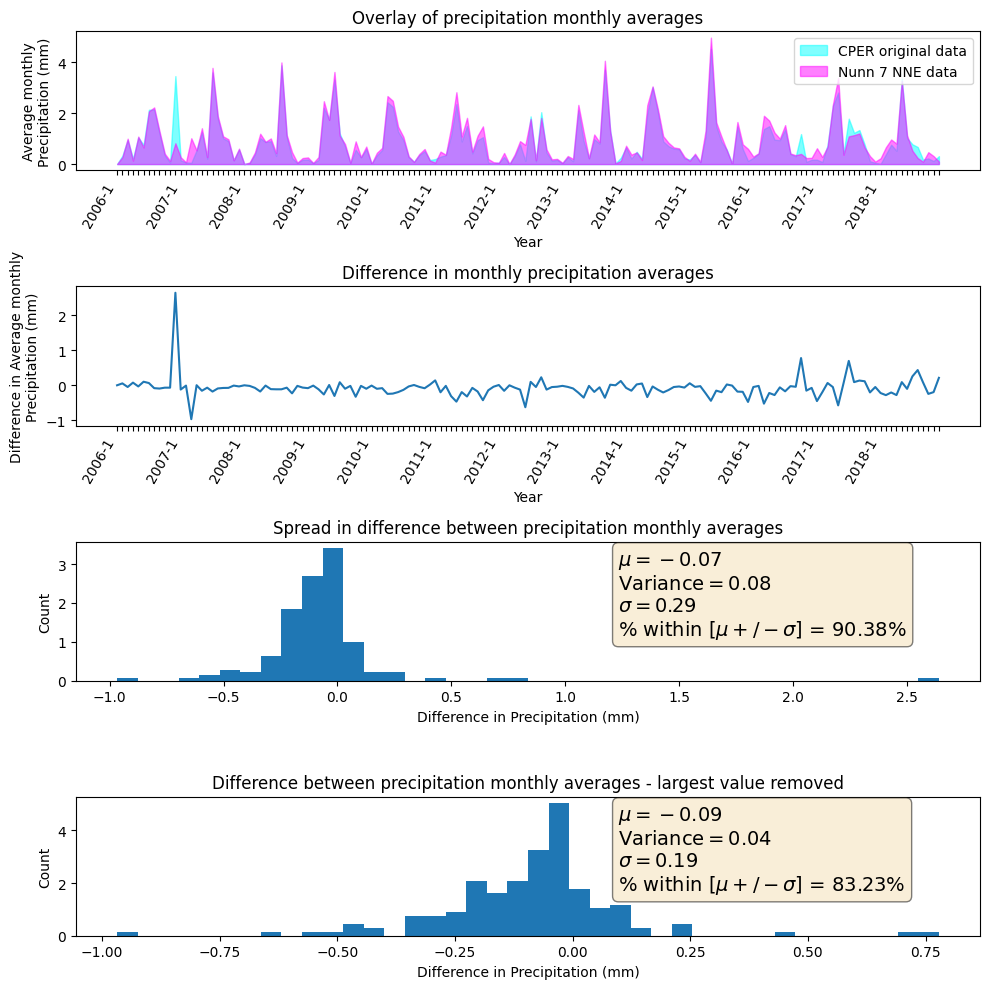

In [17]:
plot_month_avg_precipitation_variation_analysis(titles_arr, x_ys)

<p>Here we can see from month to month, there is minimal difference between the two datasets. A seen in the top plot, the vast majority of monthly average temperatures overlap, and we can see in the second plot, only a few months out of the inspected time range have differences in value of +/- 0.5 millimeters of precipitation. To better show how close the two data sets are, when their daily precipitation is averaged by month and year, the date in the second plot is shown as a hisogram in the third plot. The mean difference in precipitation between the data sets is -0.08, and when the largest value is dropped, the variance decreases by 50%, to 0.04, and are large precentage of data still remaining within +/- one standard deviation away from the mean.</p>
<p>When we take the monthly average of precipitation and temperature, we solves two problems: reducing the number of features while maintaing granularity in data over a given year, and improving the correlation between the two sets of precipitation data, leanding validity to using the temperature data from the same weather station, since monthly precipitation is strongly correlated between the CPER and Nunn 7 NNE weather station.</p>
<p></p>

<p>As a final step, we will inspect the correlation plot of one plant group with its associated features. This will show any statistical relationships between the year plant growth, monthly average temperature and monthly average rainfall.</p>

In [18]:
all_data = creat_train_test_data(get_scores_input_vars)

both_to_drop not found


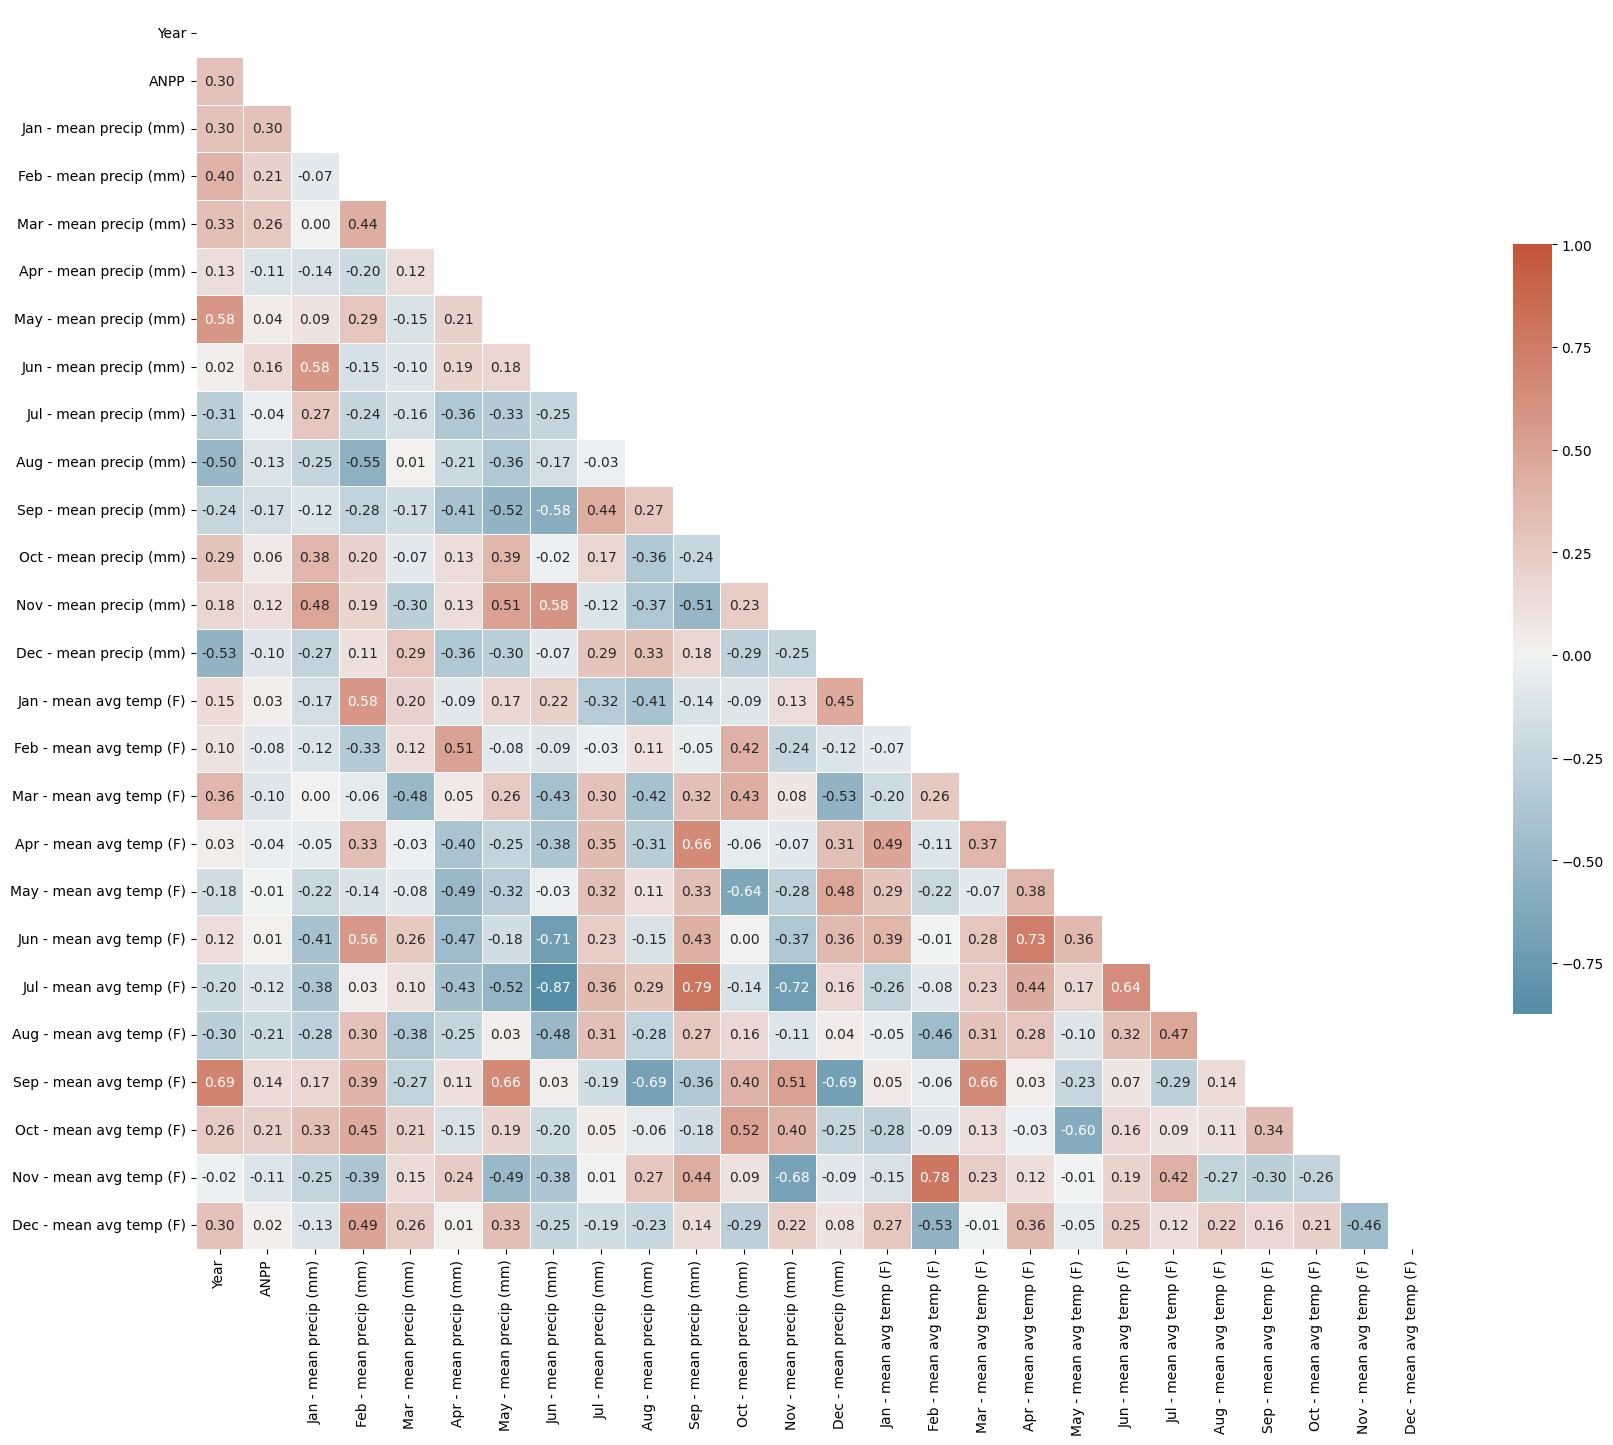

In [19]:
show_data_correlation_plot()

<p>Interestingly, there are a few strong correlations between different monthly rainfall and temperature columns. These could be explained by recurring seasonal frequency in temperature and precipitation values: if march and october have a consistant difference between their average temperatures, then you will see a large positive correlation value. This would be expected since historically, tempatures raise and fall in the same months year after year, and similarly for rainfall, i.e. the chage in seasons. Since temperature and rainfail can be correlated in this way, but are themselves created by a myriad of interacting variables and one does not determine the other, all columns will be kept.</p>
<p>Upon inspection of the ANPP column (second over, starting from the left), we can see that generally, corellation values are quite small. This indicates that no one feature is a strong predictor of growth. This lends further support to keeping all features in the model.</p>

<h2>Models</h2>


<p>For this project, I chose to focus on using support vector machines, specifically the Support Vector Regression estimator from scikitlearn.</p>
<p>I chose the SVR estimator for the following reasons:</p>
<ol>
    <li>It's effectiveness in generating models with large numbers of features</li>
    <li>Ability to use only a subset of imputed data to determine model</li>
</ol>
<p>For more details on strengths and weaknesses of Support Vector Machines, visit SciKitLearn's webpage on the subject <a href='https://scikit-learn.org/stable/modules/svm.html#classification' target="_blank">here</a></p>
<p>Due to the significant variability in plant growth when species groups are compared, seperate estimators are generated for each of the four known species groups. The data relating to the groups 'UNKN' and 'UNGR' are dropped due to the number of species in the group and species names being unknown in both instances.</p>
<h3>Tested combinations of features</h3>
<p>The tested combination of features are:</p>
<ul>
    <li>Monthly temperature average, Monthly precipitation average</li>
    <li>Monthly precipitation average</li>
    <li>Monthly temperature average</li>
</ul>
<p>The variability in growht for a givin plant group between plots and sites could pose a problem for finding a model that can use precipitation and temperature to predict plant growth. To attempt to solve this problem, we will average the growth of a species group over the different plots and transects within a given site. This will allow us to view the average plant growth for a given group by year and by site. The reasoning behind this course of acion is that given a small enough sample size (in other words, given the small area of a plot), you can get a large degree of variation between each sample. By finding the average growth for each year and each site, you can remove some of the variability.</p>
<h3>Hyperparameter tuning and cross-validation scoring</h3>
<p>In all cases, estimators will be generated using a range of hyperparameters $\mathrm{C}$ and $\mathrm{gamma}$ and evaluated using corss-validation, with the estimator achiving the greatest score being used in the final test data predictions. Hyperparameter tuning is performed initially by applying exponentially spaced sequences of parameters to a grid search, then by applying successive grid searches with new parameter sequences bounded by the next-lowest and next-highest parameter as compared to the best scoring parameters in the prior grid search. This is to ensure that successive hyperparameter grid searchs continue to focus in</p>
<p>For example, for an initial grid search where each hyperparameter range consists of 4 values you can create the parameter ranges $\mathrm{C}=[0.1, 1, 10, 100]$ and $\mathrm{gamma}=[10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}]$. If the best scoring set of parameters is $[\mathrm{C}=1$, $\mathrm{gamma}=10^{-4}]$, then the next grid search will be done using parameters $\mathrm{C}=[0.1, 0.46, 2.15, 10]$ and $\mathrm{gamma}=[10^{-5}, 4.64*10^{-5}, 2.15*10^{-4}, 2.15*10^{-3}]$</p>
<h3>Data scaling</h3>
<p>According to SKLearn, SVM estimators are not scale invariant (<a href='https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use' target="_blank">See here</a>), mean that for the same set of input data, an estimator will return different preidctions when trained on normalized data vs. unprocessed data. To address this issue, training and testing data are standardized using the StandardScaler() function and passed to the SVR estimator using the Pipline() function</p>
<h3>Effects of multicollinearity on models</h3>
<p>Upon assessing the multicollinearity of features for each of the three combinations of features listed above, it became clear that rain and temperature features were very strongly correlated, while seperately, the temperature set and rain feature set showed some strong multicollinearity but were easily trimmed to bring all VIF values below 5. The feature set of all rain and temperature features was also curated. Random sampling of features was used to determine the optimal combination of rain and temperature features to maximize number of features and keep VIF values below 5. The code used to do this is blocked out below to show the process. The set found is printed out to maintain model genreation consitancy over multiple program runs.</p>
<p>Below are displayed the VIF values for each feature in the seperate combinations. All dropped features are displayed above printed VIF values.</p>
<h3>Monthly temperature average, Monthly precipitation average</h3>

In [20]:
print('\nVIF values for select precipitation and temerature features\n')
'''
_all_cols = all_data[0]['all_data'].columns.tolist()
_cols_to_use = [x for x in _all_cols if (x != 'ANPP') & (x != 'Year')]

_max = 10
while _max > 5:
    _to_use = random.sample(_cols_to_use, 10)
    _to_use = _to_use + ['Year']
    vif = compute_vif(_to_use)
    _max = vif['VIF'].max()
    print(_max)
display(vif.max())
display(vif)
'''
_all_cols = all_data[0]['all_data'].columns.tolist()
_cols_to_use = ['Apr - mean precip (mm)', 'Aug - mean precip (mm)', 'Jan - mean avg temp (F)', 'Jan - mean precip (mm)', 'Jul - mean precip (mm)', 'May - mean precip (mm)', 'Nov - mean avg temp (F)', 'Nov - mean precip (mm)', 'Oct - mean avg temp (F)', 'Sep - mean precip (mm)', 'Year']
_to_drop = [x for x in _all_cols if (x not in _cols_to_use) & (x != 'ANPP')]
print(f'\nRemoved features: "{_to_drop}" \n')
display(compute_vif(_cols_to_use))
get_scores_input_vars['both_to_drop'] = _to_drop


VIF values for select precipitation and temerature features


Removed features: "['Feb - mean precip (mm)', 'Mar - mean precip (mm)', 'Jun - mean precip (mm)', 'Oct - mean precip (mm)', 'Dec - mean precip (mm)', 'Feb - mean avg temp (F)', 'Mar - mean avg temp (F)', 'Apr - mean avg temp (F)', 'May - mean avg temp (F)', 'Jun - mean avg temp (F)', 'Jul - mean avg temp (F)', 'Aug - mean avg temp (F)', 'Sep - mean avg temp (F)', 'Dec - mean avg temp (F)']" 



,Variable,VIF
0,Apr - mean precip (mm),3.118207
1,Aug - mean precip (mm),3.091859
2,Jan - mean avg temp (F),2.430927
3,Jan - mean precip (mm),2.631974
4,Jul - mean precip (mm),2.598742
5,May - mean precip (mm),3.540674
6,Nov - mean avg temp (F),3.927212
7,Nov - mean precip (mm),4.498820
8,Oct - mean avg temp (F),1.866389
9,Sep - mean precip (mm),2.371746


<h3>Only monthly precipitation average</h3>

In [21]:
print('\nVIF values for only precipitation features present\n')
rain_features = features_to_use(all_data[0]['all_data'],'precip')
_rain_r_f = ['Feb - mean precip (mm)', 'Jun - mean precip (mm)']
for i in _rain_r_f:
    rain_features.remove(i)
print(f'\nRemoved features: "{_rain_r_f}" \n')
display(compute_vif(rain_features))

get_scores_input_vars['rain_to_drop'] = _rain_r_f


VIF values for only precipitation features present


Removed features: "['Feb - mean precip (mm)', 'Jun - mean precip (mm)']" 



,Variable,VIF
0,Jan - mean precip (mm),2.582563
1,Mar - mean precip (mm),1.984658
2,Apr - mean precip (mm),1.617805
3,May - mean precip (mm),2.091430
4,Jul - mean precip (mm),2.192924
5,Aug - mean precip (mm),1.484426
6,Sep - mean precip (mm),2.318711
7,Oct - mean precip (mm),1.701447
8,Nov - mean precip (mm),3.152392
9,Dec - mean precip (mm),2.211621


<h3>Only monthly temperature average</h3>

In [22]:
print('\nVIF values for only temperature features present\n')
temp_features = features_to_use(all_data[0]['all_data'],'temp')
_temp_r_f = ['Jan - mean avg temp (F)', 'Jun - mean avg temp (F)', 'Nov - mean avg temp (F)']
for f in _temp_r_f:
    temp_features.remove(f)
print(f'\nRemoved features: "{_temp_r_f}" \n')
display(compute_vif(temp_features))

get_scores_input_vars['temp_to_drop'] = _temp_r_f


VIF values for only temperature features present


Removed features: "['Jan - mean avg temp (F)', 'Jun - mean avg temp (F)', 'Nov - mean avg temp (F)']" 



,Variable,VIF
0,Feb - mean avg temp (F),4.405153
1,Mar - mean avg temp (F),5.667627
2,Apr - mean avg temp (F),2.556799
3,May - mean avg temp (F),4.043790
4,Jul - mean avg temp (F),3.114295
5,Aug - mean avg temp (F),3.315267
6,Sep - mean avg temp (F),5.255021
7,Oct - mean avg temp (F),2.801953
8,Dec - mean avg temp (F),2.320023


<p>With the model features trimmed so that simulations run with just precipitation or just temperature will have low VIF values and minimal multicolinearity, we create our models.</p>

In [23]:
get_scores_input_vars['num_reps'] = 2
get_scores_input_vars['test_num'] = 5

get_scores_input_vars['use_rain']=True
get_scores_input_vars['use_temp']=False
new_scores_rain = get_scores_optimize(get_scores_input_vars)

get_scores_input_vars['use_rain']=False
get_scores_input_vars['use_temp']=True
new_scores_temp = get_scores_optimize(get_scores_input_vars)

get_scores_input_vars['use_rain']=True
get_scores_input_vars['use_temp']=True
new_scores_both = get_scores_optimize(get_scores_input_vars)


<h2>Results and Analysis</h2>

<h3>Model Results/Predictions</h3>

<p>Using the best estimators from the investigation, we can inspect how well each one was able to predict the change in a species groups growth. Due to the large number of plots that could be generated, we will look at the plant group CSAG for all sites, since as we will see later, depending on the site, the SVR models did best or worst overall when trying to predict CSAG ANPP across the three sites. We will see all models cross-validation scores and R2 scores later on.</p>
<p>Plot descriptions:</p>
<ul>
    <li>left plot: predicted plant growth in red, with the expected plant growths shown as dark blue dots. </li>
        <ul>
            <li>The shaded areas are to show the variation between what the models predictions are and the minimum and maximum plant growth amounts represented in the data.</li>
            <li>The reason why you are seeing multiple blue dots instead of just one is because this plot shows each growth amount for each plot at a given site, a total of 18 in most cases.</li>
        </ul>
    <li>center plot: the average of the expected plant growths amount is found, so each year has a single expected value, with the red line represented predicted values and the blue line representing the average of expected values.</li>
    <li>right plot: you can see which features mattered the most for this model, in terms of how much of the total r2 value they represent. </li>
    <ul>
        <li>Importance was found using SKlearn permutation_importance(), which generates models with successivly smaller sets of feature permutations and calculates affect the absence of feature has on model performance. SVR's have no internal mechanisms to keep track or calculate feature importance like other regression models.</li>
    </ul>
</ul>

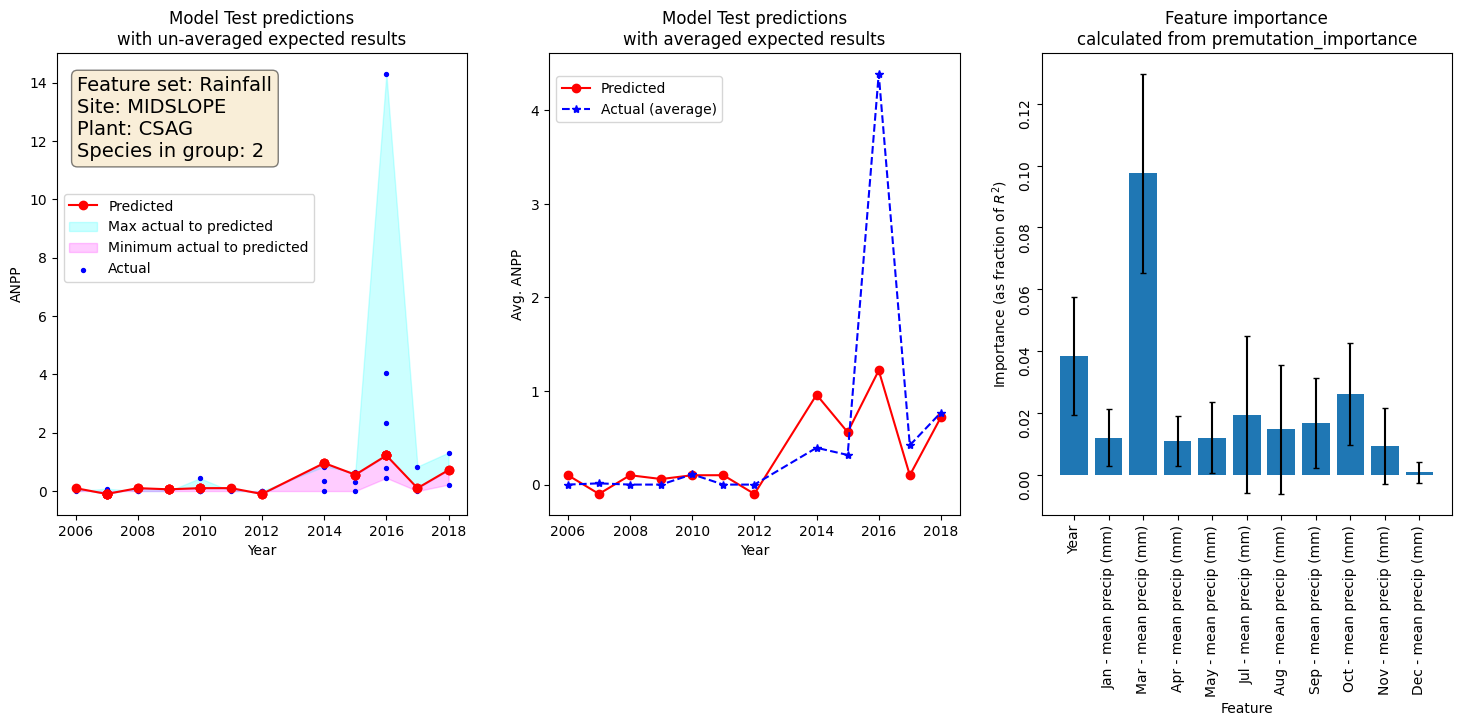

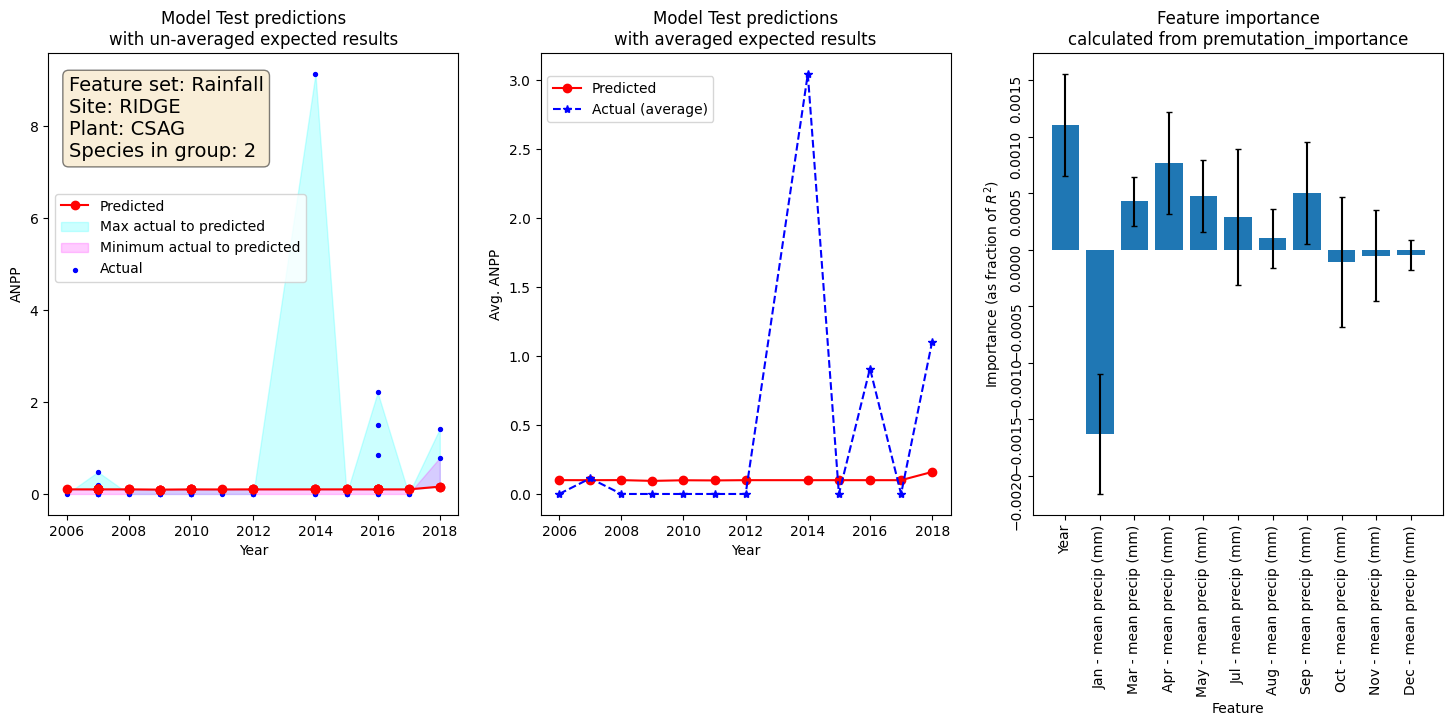

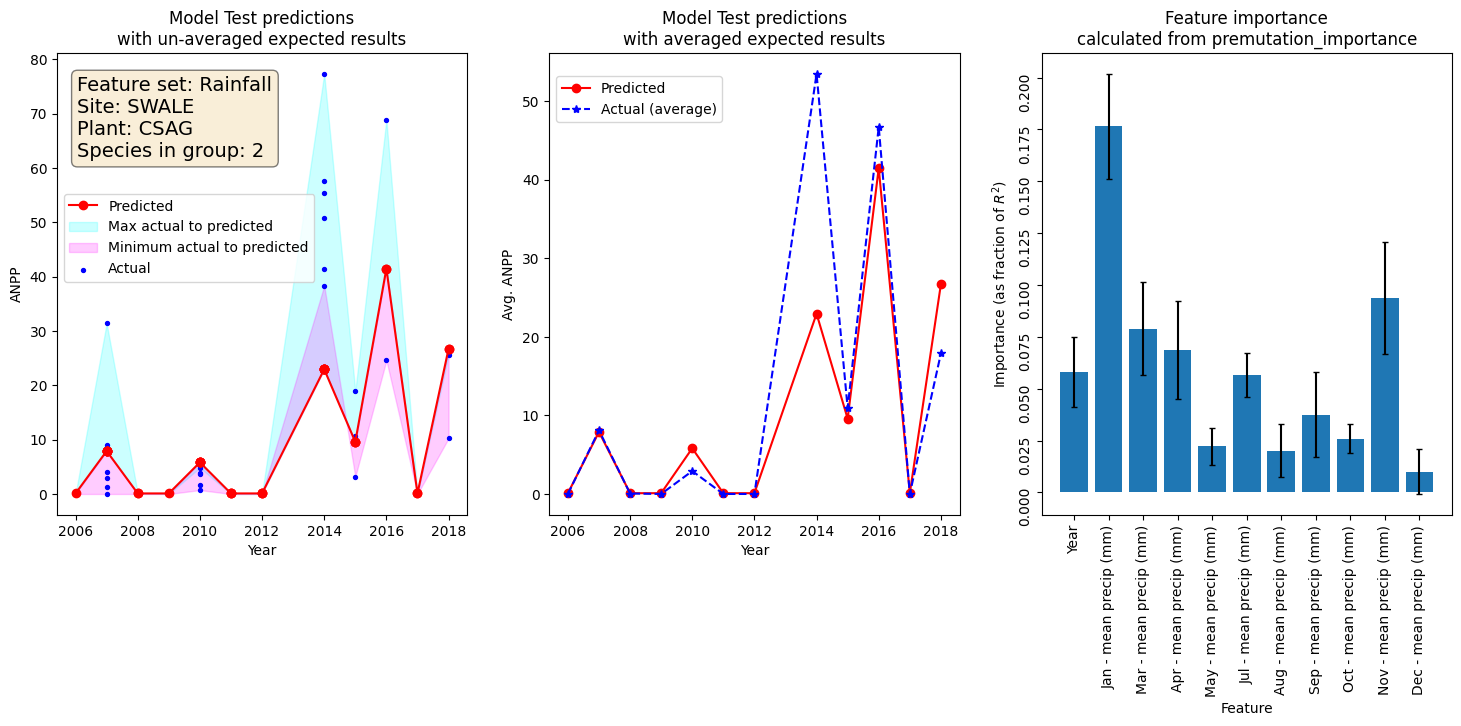

In [24]:
plot_predictions(new_scores_rain,0,'Rainfall','CSAG')

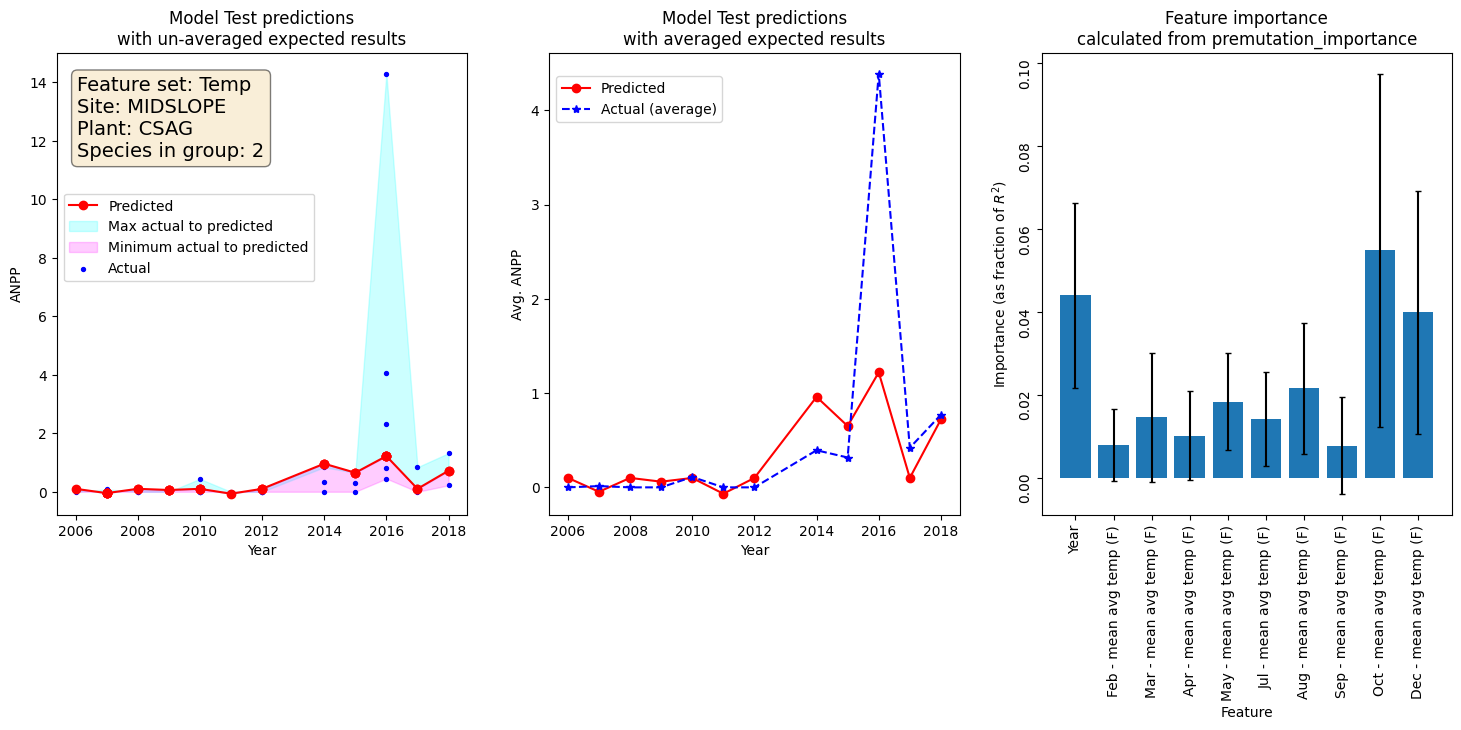

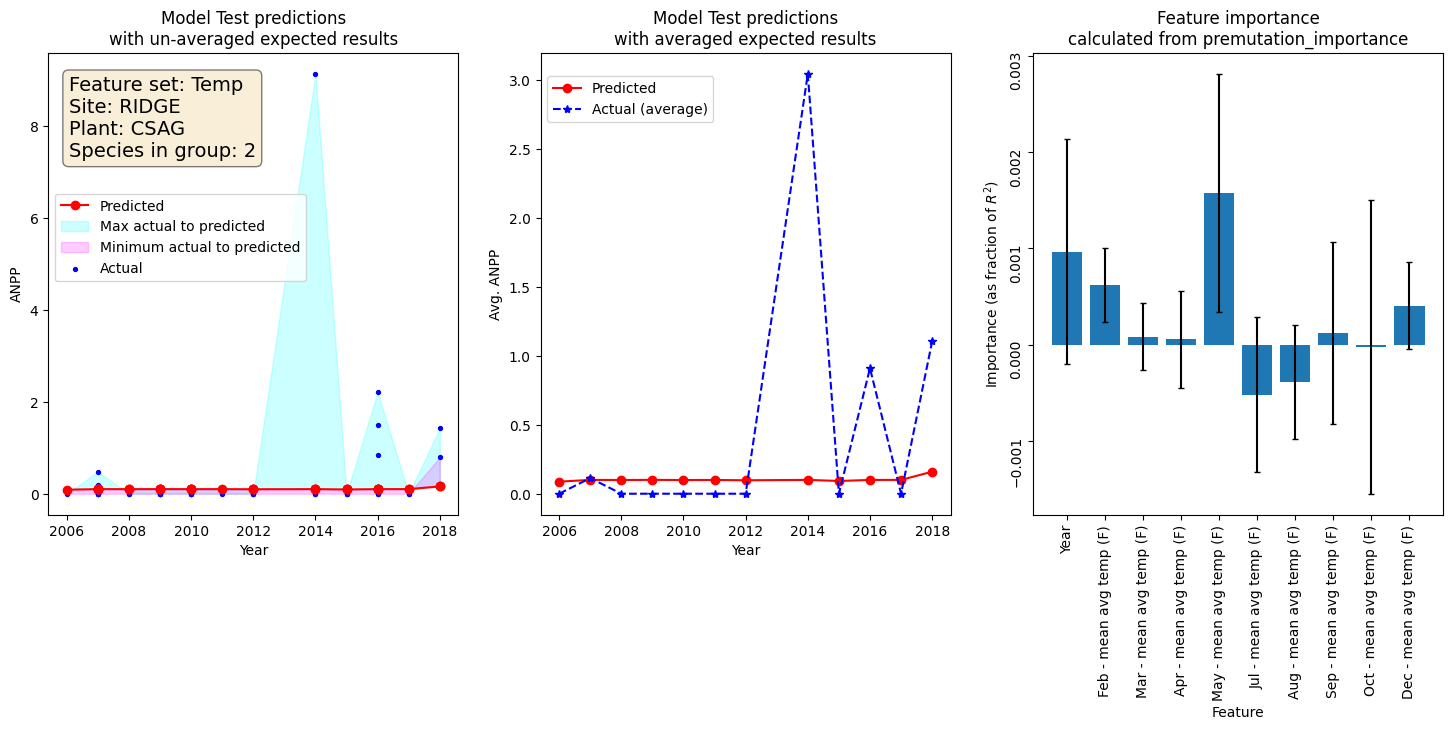

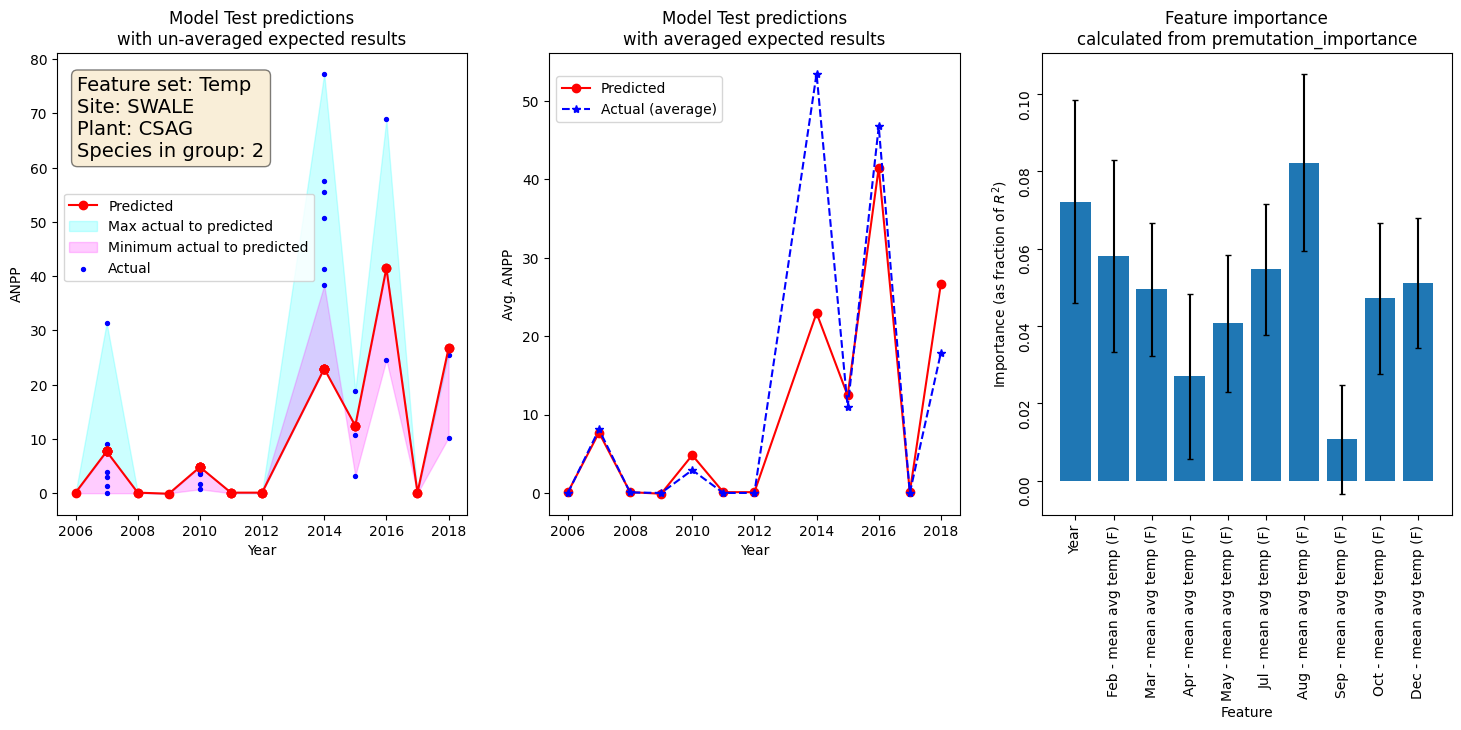

In [25]:
plot_predictions(new_scores_temp,0,'Temp','CSAG')

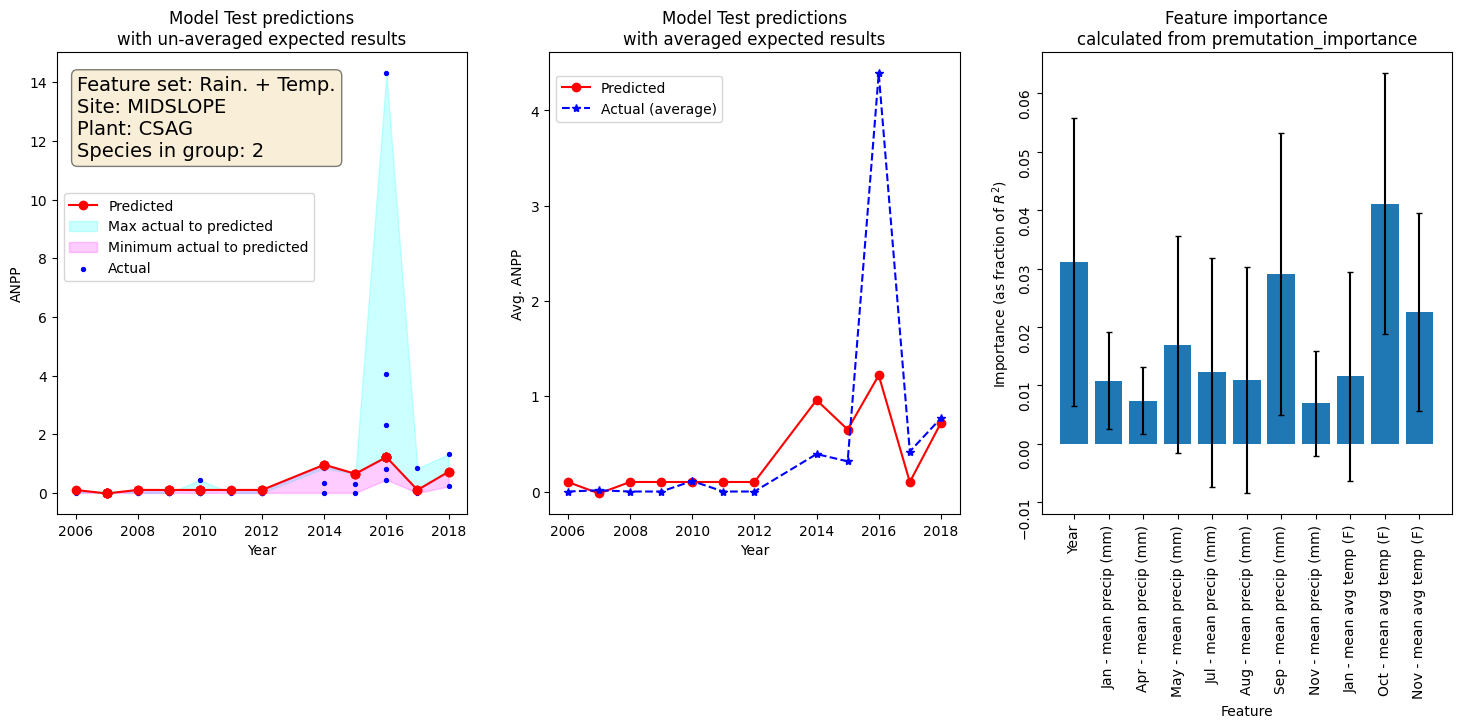

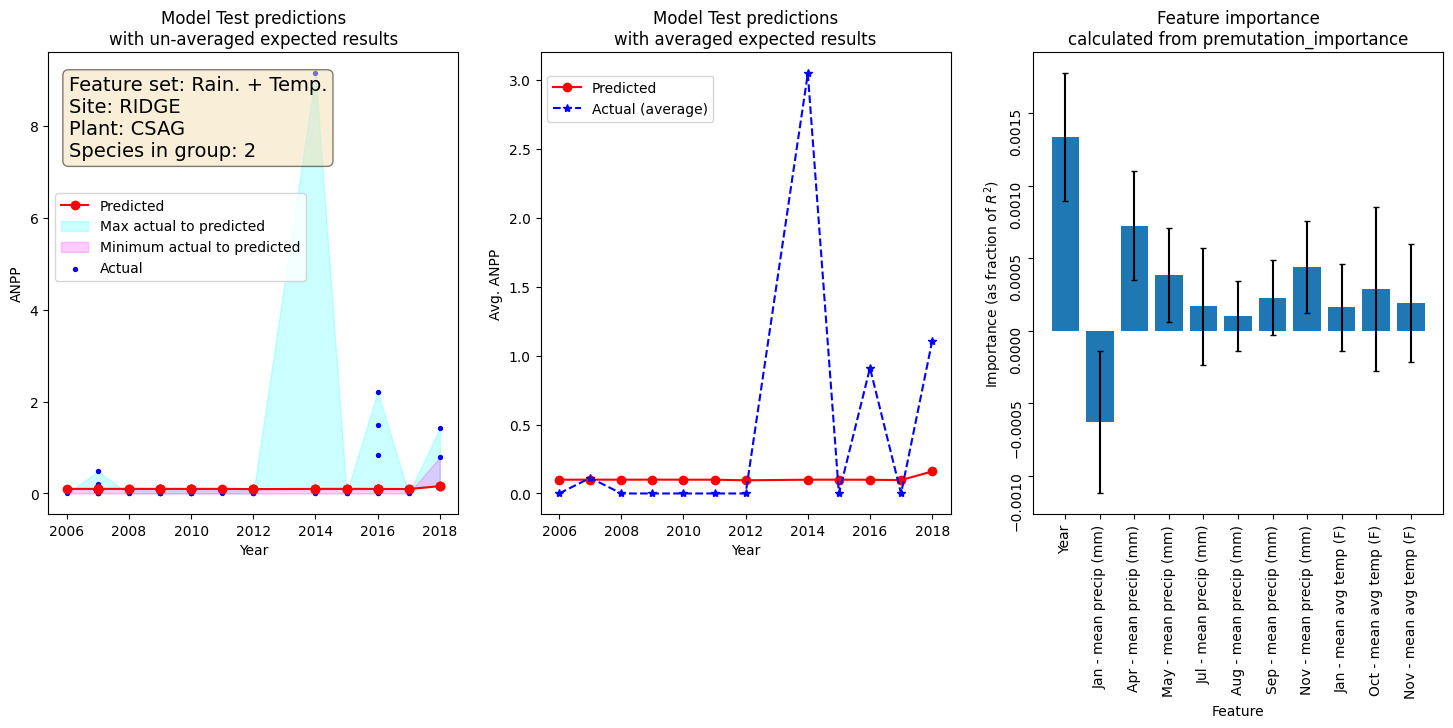

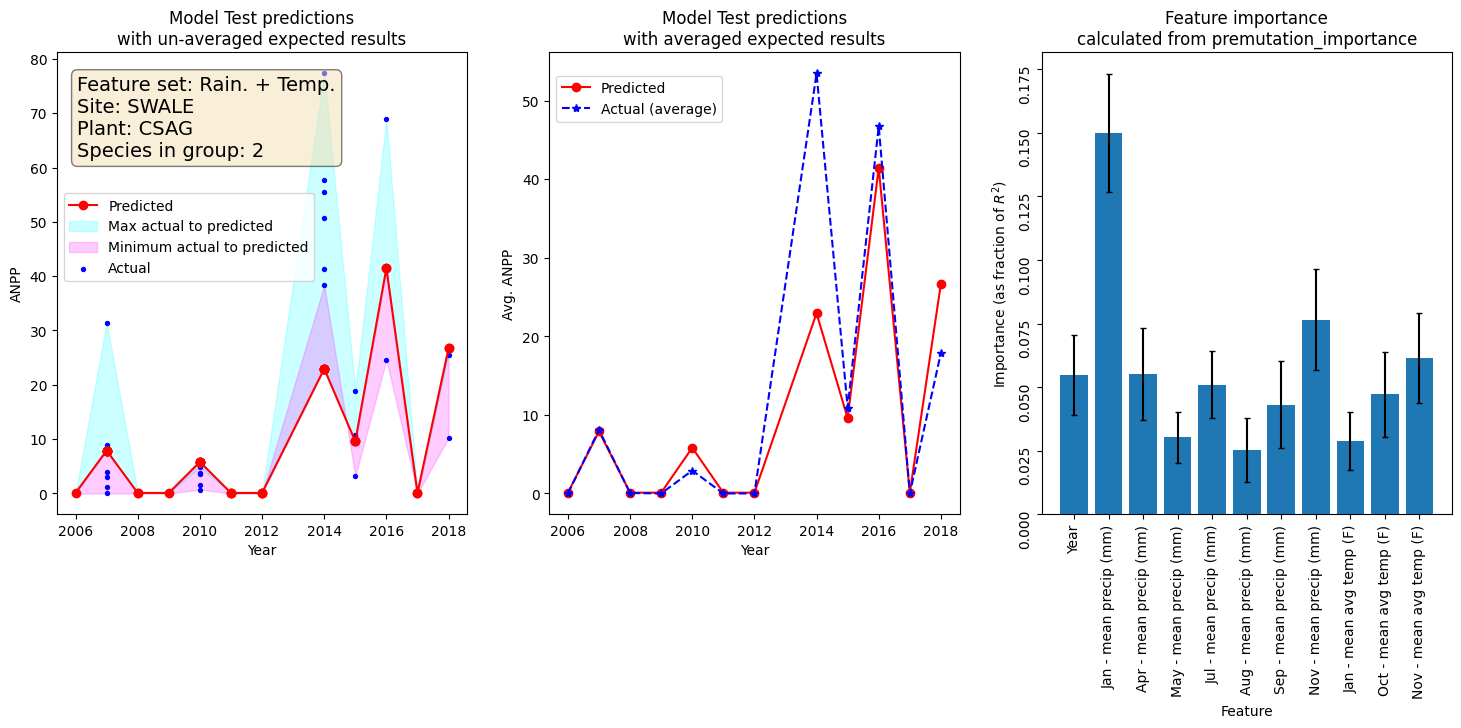

In [26]:
plot_predictions(new_scores_both,0,'Rain. + Temp.','CSAG')

<h3>Analysis</h3>

<p>In the plots generated above, it is possible to see a few consistant features appear for each particular site.</p>
<ol>
    <li>For the grass group CSAG, the site location strongly determined how well the best fit SVR model could do, which was in turn appears to be due to the fact that CSAG had starkly different ANPP amounts when it has sampled in 'RIDGE', 'MIDSLOPE', or 'SWALE'. In the 'RIDGE' case, there was almost no recorded growth over the dates investigated, and the model did exceptionally poorly. In 'SWALE', there was substantial ANPP year to year and the model was model was able to use that to stronly predict the yearly ANPP from just precipitation, just temperature or both.</li>
    <li>In models that did well in predicting CSAG ANPP generation, temperature and precipitation early in the year had the strongest influence on model predictive strength. The influence is not vastly greater than other features (i.e. other months precipitation and/or temperature values) but in the case of CSAG, the plant groups yearly ANPP seems to depend strongly on those range of months.</li>
    <li>Since the data input into the models all had the same temperature and/or precipitation data associated with it, if the data fell within the same year, when you try to compare the model predictions to the actual data, it appears that the model did not do great. However, since the model is trying to do the best it can to generally prict ANPP generation, if we average the expected ANPP levels for each year, we can see that the models that perform well actually do even better.</li>
</ol>


<p>Let us look now at the different optimal cross-validataion scores and $R^2$ scores for each of the models.</p>

In [27]:
rain_dfs = get_all_scores(new_scores_rain)
temp_dfs = get_all_scores(new_scores_temp)
both_dfs = get_all_scores(new_scores_both)

rain_r2_dfs = get_all_r2_scores(new_scores_rain)
temp_r2_dfs = get_all_r2_scores(new_scores_temp)
both_r2_dfs = get_all_r2_scores(new_scores_both)

<p>Utilizing modified code from matplotlib tutorials (<a href='https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html' target="_blank">Click here</a> to see original tutorial), we can see the change in scross-validation score over the corse of hyper parameter turning.</p>

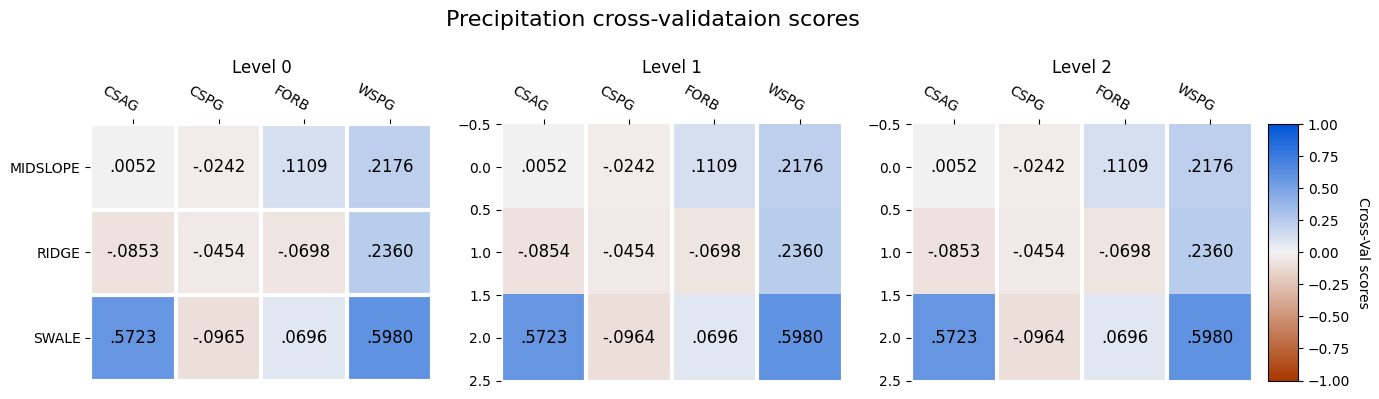

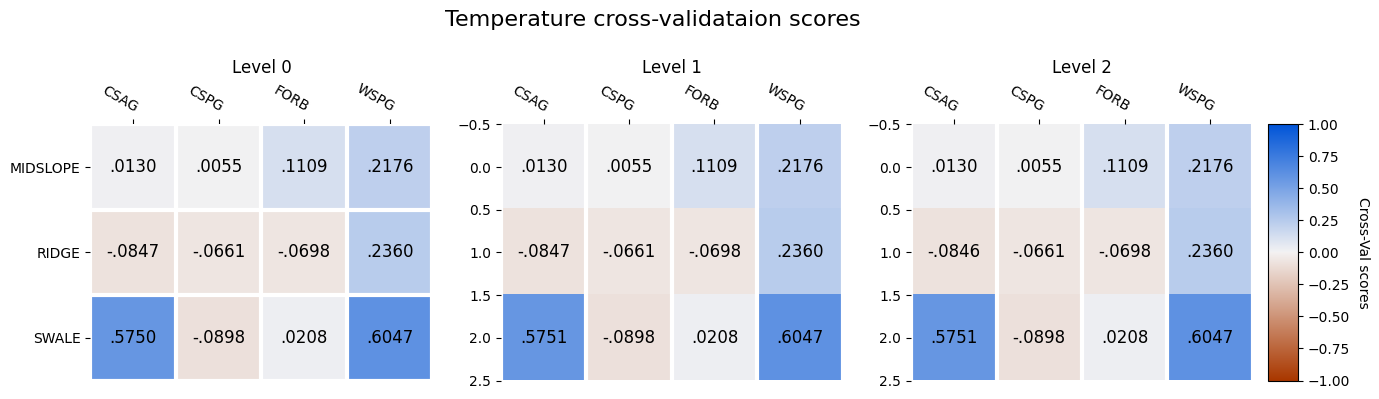

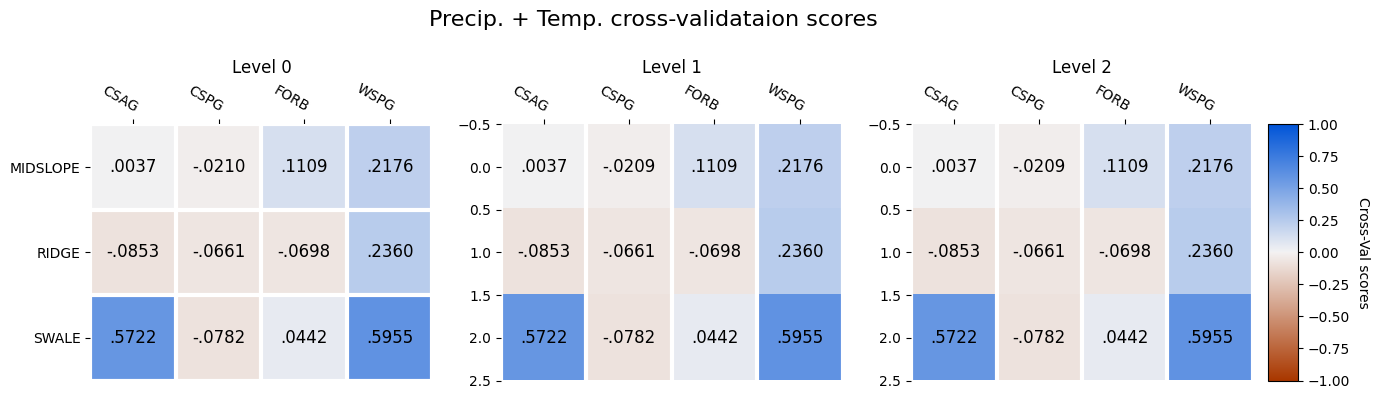

In [28]:
_addon = ' cross-validataion scores'
cv_husl = (20, 260, 40, 100)
all_dfs = [[rain_dfs, 'Precipitation' + _addon], [temp_dfs, 'Temperature' + _addon], [both_dfs, 'Precip. + Temp.' + _addon]]
plot_all_scores(all_dfs, husl=cv_husl)

<p>We can see that for all models run, the cross-validation scores barely changed from level to level, if at all. The grid searchs for each estimator were able to find the best hyperparameters on the first run, negating the need to run more grid searches.</p>
<p>In addition, accross feature combinations, each model was able to reach roughly the same value for a cross-validation score. This is similar to the R^2 scores the models generated as well, when scoring how well their predictions on test data matched the correct results they should be achieving.</p>

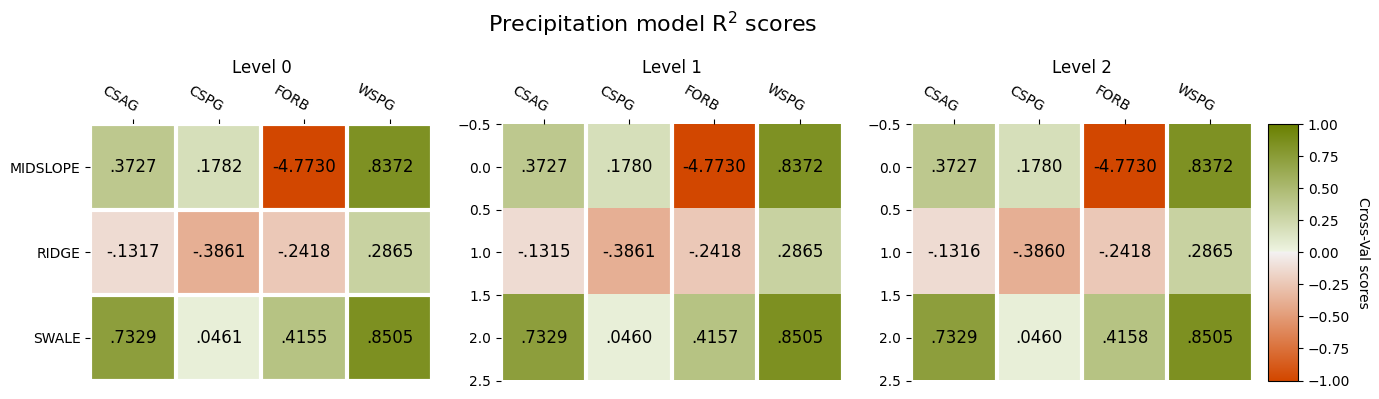

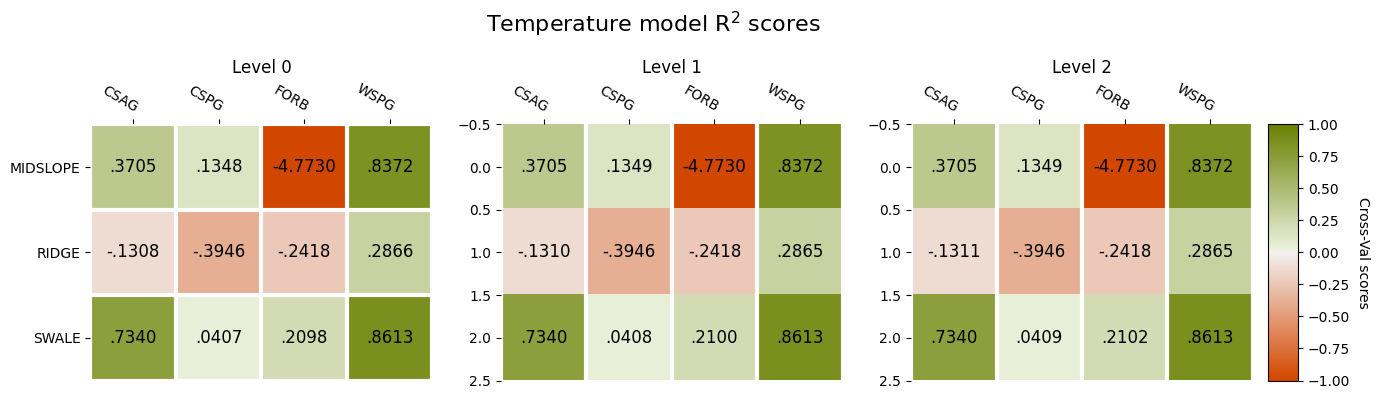

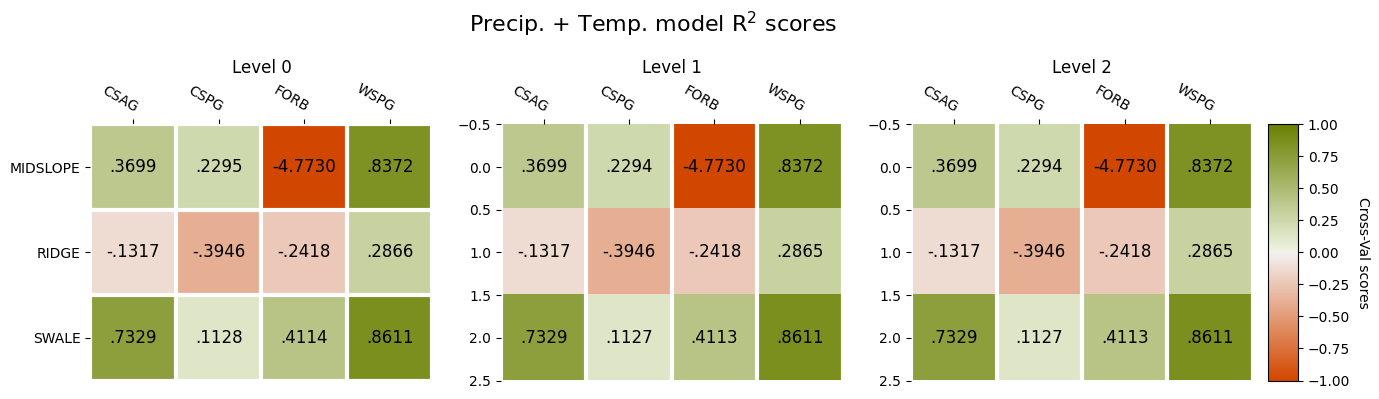

In [29]:
r2_husl = (20, 100, 50, 100)
_addon = ' model $\mathrm{R^2}$ scores'
all_dfs = [[rain_r2_dfs, 'Precipitation' + _addon], [temp_r2_dfs, 'Temperature' + _addon], [both_r2_dfs, 'Precip. + Temp.' + _addon]]
plot_all_scores(all_dfs, husl=r2_husl)

<p>We can see that when looking at one plant group for one site, there is not much improvement in model accuracy if both temperature and precipitation data is used, as opposed to using one or the other. The models using only monthly temperature could in some cases outperform models using only monthly precipitation as well.</p>
<p>Suprisingly, the ability of a given model to predict ANPP depends not just on which combination of features is used, but on which combination of features are used for a given site. For instance, as we saw in the plots showing the pricted vs. expected ANPP levels for CSAG earlier, we can see here that for CSAG, rainfall by itself was better able to predict ANPP generation for the 'MIDSLOPE' site than the precip.+temp. feature set, yet rainfall was far worse at predicting CSAG ANPP generation in the "SWALE' site than the temperature or the precip.+temp. feature set. These differences in model accuracy are marginal however, and could undergo further statistical analysis to determine if the differences are significant.</p>
<p>Additionally, we can see from the grids above that the SVR estimators could do very well or very poorly when predicting the ANPP of a given plant group. This in some ways is not suprising, as it is quite possible that certain plant groups are made up of species that repsond more or less strongly to rainfall and temperature. In other words, the grow better or worse in different environments. However, it is interesting that some groups ANPP genereation could be explained so well by just temperature or rainfall, while others could not be explained at all by either or both. For example, CSPG ANPP in the 'SWALE' site could not be predicted well in any model, while WSPG ANPP could be predicted decently by rainfall and exceptionally well by temperature or the combination of rainfall adn temperature, for any site</p>

<h2>Conclusion</h2>

<h3>Takeaways</h3>
<p>Here we learn that independantly, the monthly temperature and rainfall data for a given year is only good for a few plant species groups growth, when it comes to training SVR models to generate good predictions. For plant groups and sites that the models struggled with, it is possible that feature optimization of already present features and including more features, such as humidity or soil temperature, could improve their predictive power.</p>
<p>In addition, when both monthly precipitation and temperature features are used in model creation, the SVR models do slighly better at predicting the plant growths overall, but do not out perform models using just temperature or rainfall in some instances, and did just as poorly or even more poorly at predicting the growths for the same groups that other models struggled with.</p>
<h3>What went wrong</h3>
<p>It is interesting that the SVR models could do decently well predicting some plant groups yearly growth, but could do so poorly predicting the growth of others. This could have been due to the fact that for models that did poorly, they had data that contained strong outliers and/or were comprised of data that had values close to zero.</p>
<p>It also was revealed to be unnecessary to try to 'borrow down' to a more precise set of hyperparameters for the different models. From the very first grid search, the models were able to find quite optimal values for their parameters. The additional iterations through more grid searches had no valuable changes in paramters</p>
<h3>Ways to improve</h3>
<p>Some steps that could be taken to improve model prediction accuracy is to:</p> 
<ol>
    <li>Include more features that do not share strong multicollinearity with the original features (i.e. potentially daily humidity values, or soil temperature, nutrient levels, and mosture content.)</li>
    <li>Apply different ML models (i.e. Random forest) and/or types of regression</li>
    <li>Create additional SVR estimators for each plant group and site using additional permutations of features, instead of the same set of percipitation, temperature, and precip.+temp. features used for all models.</li>
    <li>When testing different hyperparameters, it is possible that having one large grid search over many possible values is more computationally adavantagious then iterating thorugh mutliple grid searchs, in the hopes of minimizing test numbers.</li>
</ol>